In [1]:
## Import packages ##
# File I/O
import os
from datetime import datetime

# Data structures and basic operations
import numpy as np
import pandas as pd
import anndata as ad
import scipy.sparse as sp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Runtime warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='anndata')
warnings.filterwarnings('ignore', category=FutureWarning, module='anndata')

In [2]:
## Directory information ##

# get current working directory
cwd = os.getcwd()

# Change cwd to the base directory
os.chdir(os.path.join(cwd, '..', '..'))

#Input
input_file='test_anndatas/dCas9_m6A_invitro_kinetics.h5ad.gz'

# Output
output_directory='images'

In [3]:
# Get the current date
current_date = datetime.now()
# Format the date as a string
date_string = current_date.strftime("%Y%m%d")
date_string = date_string[2:]

# Define a function to get current timestamp
def time_string(sep=':'):
    current_time = datetime.now()
    return current_time.strftime(f"%H{sep}%M{sep}%S")

In [4]:
## Define functions ##

def adata_to_df(adata):
    """
    Takes in an anndata object and returns a dataframe
    """
    # Extract the data matrix
    data_matrix = adata.X
    # Extract observation (read) annotations
    obs_df = adata.obs
    # Extract variable (position) annotations
    var_df = adata.var
    # Convert data matrix and annotations to pandas DataFrames
    df = pd.DataFrame(data_matrix, index=obs_df.index, columns=var_df.index)
    return df

def filter_adata_by_nan_proportion(adata, threshold, axis='obs'):
    if axis == 'obs':
        # Calculate the proportion of NaN values in each read
        nan_proportion = np.isnan(adata.X).mean(axis=1)
        # Filter reads to keep reads with less than a certain NaN proportion
        filtered_indices = np.where(nan_proportion <= threshold)[0]
        filtered_adata = adata[filtered_indices, :]
    elif axis == 'var':
        # Calculate the proportion of NaN values at a given position
        nan_proportion = np.isnan(adata.X).mean(axis=0)
        # Filter positions to keep positions with less than a certain NaN proportion
        filtered_indices = np.where(nan_proportion <= threshold)[0]
        filtered_adata = adata[:, filtered_indices]
    else:
        raise ValueError("Axis must be either 'obs' or 'var'")
    return filtered_adata

def calculate_correlation_matrix(df):
    # Initialize an empty matrix to store the correlation coefficients
    n_cols = len(df.columns)
    correlation_matrix = np.zeros((n_cols, n_cols), dtype=float)
    print('{0}: Calculating correlation matrix'.format(time_string()))
    # Iterate through each pair of columns
    for i in range(n_cols):
        print('{0}: Progress {1}%'.format(time_string(), 100*i/n_cols))
        for j in range(n_cols):
            # Calculate the correlation coefficient for the pair (i, j)
            correlation_matrix[i, j] = df.iloc[:, i].corr(df.iloc[:, j], method='pearson', min_periods=1)
    return correlation_matrix

def pair_heatmap_plot(matrix, title, xlabel, ylabel, save, save_name, cmap='coolwarm', colorbar_label=False, vmax=False):
    fig, axes = plt.subplots(figsize=(12, 6))
    if save:
        dpi = 3000
    else:
        dpi = 300
    fig.set_dpi(dpi)
    if vmax:
        sns.heatmap(matrix, annot=False, cmap=cmap, fmt='.2f', linewidths=0, cbar=True, ax=axes, vmax=vmax)
    else:
        sns.heatmap(matrix, annot=False, cmap=cmap, fmt='.2f', linewidths=0, cbar=True, ax=axes)
    axes.set_title('')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params(axis='x', rotation=70)
    fig.suptitle(title)
    if colorbar_label:
        colorbar = axes.collections[0].colorbar
        colorbar.set_label(colorbar_label)
    else:
        pass
    # axes.set_xticks(np.arange(0.5, len(df_sorted.columns)))
    # axes.set_xticklabels(df_sorted.columns)
    # axes.set_yticks(np.arange(0.5, len(df_sorted.columns)))
    # axes.set_yticklabels(df_sorted.columns)
    plt.tight_layout()
    if save:
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.show()
    return

def calculate_combinations_matrix_numpy(df):
    matrix = df.to_numpy()
    matrix = np.nan_to_num(matrix,nan=2)
    n_cols = matrix.shape[1]
    combinations_matrix = np.zeros((n_cols, n_cols, 4))
    print('{0}: Calculating combination matrix'.format(time_string()))
    # Iterate through each pair of columns
    for i in range(n_cols):
        for j in range(n_cols):
            # Count the occurrences of '1-1', '1-0', '0-1', and '0-0' for the pair (i, j)
            count_11 = np.nansum((matrix[:, i] == 1) & (matrix[:, j] == 1))
            count_10 = np.nansum((matrix[:, i] == 1) & (matrix[:, j] == 0))
            count_01 = np.nansum((matrix[:, i] == 0) & (matrix[:, j] == 1))
            count_00 = np.nansum((matrix[:, i] == 0) & (matrix[:, j] == 0))
            
            # Store the counts in the combinations matrix
            combinations_matrix[i, j, 0] = count_11/matrix.shape[0]
            combinations_matrix[i, j, 1] = count_10/matrix.shape[0]
            combinations_matrix[i, j, 2] = count_01/matrix.shape[0]
            combinations_matrix[i, j, 3] = count_00/matrix.shape[0]
    
    return combinations_matrix


In [5]:
## Read in the input h5ad file as adata ##
adata = ad.read_h5ad(input_file)
print(adata)

AnnData object with n_obs × n_vars = 24490 × 670
    obs: 'Sample', 'Dataset', 'Sample_names'


In [8]:
adata.obs

Sample          Dataset    Sample_names
770e6271-bee7-4e03-89dc-0d7f5bd3f24a      0  m6A_plus_strand      15min Hia5
b6bc7f78-6241-4b39-943c-b70be185c300      0  m6A_plus_strand      15min Hia5
ce92f4d7-083f-45c0-9529-b0ac2bb93fe3      0  m6A_plus_strand      15min Hia5
c2878519-2529-48fe-86b6-ad6cd0dae54a      0  m6A_plus_strand      15min Hia5
fc161cfa-b2e1-4e83-9c49-33d3387bc51e      0  m6A_plus_strand      15min Hia5
...                                     ...              ...             ...
0f979bb3-c088-4037-b084-570ad829b0b6      6  m6A_plus_strand  30min No MTase
ea90553d-349a-4760-9da5-7399537eda88      6  m6A_plus_strand  30min No MTase
7a9e24db-2610-455e-b583-1c6584bcda95      6  m6A_plus_strand  30min No MTase
38e29ff2-34d9-4475-a1c0-c41015814ffe      6  m6A_plus_strand  30min No MTase
33629b02-5c75-46b6-9147-d554a2743a16      6  m6A_plus_strand  30min No MTase

[24490 rows x 3 columns]

In [7]:
# Define the mapping from old values to new values
value_mapping = {
    '0': '15min Hia5',
    '1': '30min Hia5',
    '2': '15min Tandem',
    '3': '30min Tandem',
    '4': '15min GpC',
    '5': '30min GpC',
    '6': '30min No MTase',
}

# Create a new observation column based on the mapping
adata.obs['Sample_names'] = adata.obs['Sample'].map(value_mapping)
adata.obs

Sample          Dataset    Sample_names
770e6271-bee7-4e03-89dc-0d7f5bd3f24a      0  m6A_plus_strand      15min Hia5
b6bc7f78-6241-4b39-943c-b70be185c300      0  m6A_plus_strand      15min Hia5
ce92f4d7-083f-45c0-9529-b0ac2bb93fe3      0  m6A_plus_strand      15min Hia5
c2878519-2529-48fe-86b6-ad6cd0dae54a      0  m6A_plus_strand      15min Hia5
fc161cfa-b2e1-4e83-9c49-33d3387bc51e      0  m6A_plus_strand      15min Hia5
...                                     ...              ...             ...
0f979bb3-c088-4037-b084-570ad829b0b6      6  m6A_plus_strand  30min No MTase
ea90553d-349a-4760-9da5-7399537eda88      6  m6A_plus_strand  30min No MTase
7a9e24db-2610-455e-b583-1c6584bcda95      6  m6A_plus_strand  30min No MTase
38e29ff2-34d9-4475-a1c0-c41015814ffe      6  m6A_plus_strand  30min No MTase
33629b02-5c75-46b6-9147-d554a2743a16      6  m6A_plus_strand  30min No MTase

[24490 rows x 3 columns]

In [8]:
## Filtering adata to keep certain observation types, coordinate ranges, and reads/positions with a maximal np.nan content

## Parameters ##
# Filter to keep a coordinate range
filter_on_coordinates, lower_bound, upper_bound = [True, 3600, 3800]
# Filter to keep positions with less than a given np.nan proportion
filter_columns_on_nan, position_nan_threshold = [True, 0.8] 
# Keep only reads that have less than the given nan frequency
filter_rows_on_nan, read_nan_threshold = [True, 0.20] 
# Define the observation type of interest and define which observation values you want to keep
category_of_interest = 'Dataset'
dataset_types = ['m6A_plus_strand']
datasets_to_analyze = [0]
adata_suffix = '_subset_filtered'
##

# Initialize a dictionary to store subsets for each dataset of interest. Keys will be dataset instances. Values will be a list of tuples. Each tuple contains a descriptor string for the adata object, as well as an adata object
adata_dict = {}

## Iterate over the dataset_types list
for i, dataset in enumerate(dataset_types):
    # Analyze only the datasets of interest
    if i in datasets_to_analyze:
        # Initialize a new sub dictionary for the top level dataset of interest.
        adata_dict[dataset] = {}
        print('{0}: Iterating over {1} Dataset'.format(time_string(), dataset))
        # Subset and keep only the Dataset of interest
        value_to_keep = dataset
        print('{0}: Initial adata {1}'.format(time_string(), adata))
        print('{0}: Subsetting adata to keep {1} Dataset'.format(time_string(), dataset))
        adata_subset = adata[adata.obs[category_of_interest] == value_to_keep].copy()
        print('{0}: adata_subset {1}'.format(time_string(), adata_subset))

        if filter_on_coordinates:
            # Subset and keep positions within the specified coordinate range
            position_list = list(range(lower_bound, upper_bound + 1))
            position_list = [str(pos) for pos in position_list]
            position_set = set(position_list)
            print('{0}: Subsetting adata to keep data between coordinates {1} and {2}'.format(time_string(), lower_bound, upper_bound))
            adata_subset = adata_subset[:, adata_subset.var_names.isin(position_set)].copy()
            print('{0}: adata_subset {1}'.format(time_string(), adata_subset))

        if filter_columns_on_nan:
            # Remove positions that have over a certain frequency of nan values
            print('{0}: Subsetting adata to keep positions with atleast {1} percent of data coverage for coordinates in the defined window'.format(time_string(), position_nan_threshold*100))
            adata_subset = filter_adata_by_nan_proportion(adata_subset.copy(), position_nan_threshold, axis='var')
            print('{0}: adata_subset {1}'.format(time_string(), adata_subset))

        if filter_rows_on_nan:
            # Remove reads that have over a certain frequency of nan values
            print('{0}: Subsetting adata to keep reads with atleast {1} percent of data for coordinates in the defined window'.format(time_string(), read_nan_threshold*100))
            adata_subset = filter_adata_by_nan_proportion(adata_subset.copy(), read_nan_threshold, axis='obs')
            print('{0}: adata_subset {1}'.format(time_string(), adata_subset))

        # Add the filtered subset to the dictionary
        adata_dict[dataset][f'{dataset}{adata_suffix}'] = adata_subset.copy()         
            
print(f'Current adata of interest: {adata_suffix}')

21:23:22: Iterating over m6A_plus_strand Dataset
21:23:22: Initial adata AnnData object with n_obs × n_vars = 24490 × 670
    obs: 'Sample', 'Dataset', 'Sample_names'
21:23:22: Subsetting adata to keep m6A_plus_strand Dataset
21:23:22: adata_subset AnnData object with n_obs × n_vars = 24490 × 670
    obs: 'Sample', 'Dataset', 'Sample_names'
21:23:22: Subsetting adata to keep data between coordinates 3600 and 3800
21:23:22: adata_subset AnnData object with n_obs × n_vars = 24490 × 37
    obs: 'Sample', 'Dataset', 'Sample_names'
21:23:22: Subsetting adata to keep positions with atleast 80.0 percent of data coverage for coordinates in the defined window
21:23:22: adata_subset View of AnnData object with n_obs × n_vars = 24490 × 37
    obs: 'Sample', 'Dataset', 'Sample_names'
21:23:22: Subsetting adata to keep reads with atleast 20.0 percent of data for coordinates in the defined window
21:23:22: adata_subset View of AnnData object with n_obs × n_vars = 1660 × 37
    obs: 'Sample', 'Datase

In [9]:
## Calculate the average methylation density within each read and optionally filter dataset on a minimum methylation threshold
## Parameters ##
filter_min_methylation, min_read_methylation = [False, 0] # Minimal mean methylation quantity in read to keep the read
methylation_suffix = ''
#################

for dataset in adata_dict.keys():
    input_adata_name = f'{dataset}{adata_suffix}'
    input_adata = adata_dict[dataset][input_adata_name]
    # Calculate the average methylation density within each read
    print('{0}: Calculating the mean methlyation state of each read'.format(time_string()))
    read_methylation_mean_values = np.nanmean(input_adata.X, axis=1)
    input_adata.obs['mean_methylation'] = pd.Series(read_methylation_mean_values, dtype=np.float32)

    if filter_min_methylation:
        # Filter reads to keep reads with at least a certain methylation frequency
        filtered_indices = np.where(read_methylation_mean_values >= min_read_methylation)[0]
        print('{0}: Subsetting adata_subset to keep reads with at least {1} percent methylation'.format(time_string(), min_read_methylation*100))
        adata_subset = input_adata[filtered_indices, :]
        print('{0}: adata_subset {1}'.format(time_string(), adata_subset))
        methylation_suffix = '_methylation_filtered'
        adata_dict[dataset][f'{input_adata_name}{methylation_suffix}'] = adata_subset 

# Define the new adata_suffix for the adata object of interest
adata_suffix = adata_suffix+methylation_suffix    
print(f'Current adata of interest: {adata_suffix}')

21:23:42: Calculating the mean methlyation state of each read
Current adata of interest: _subset_filtered


In [10]:
# Take the filtered adata obects and create an object that replaces np.nan values with a replacement strategy of interest.

## Parameters ##
# Choose one of the nan fill strategies that you want to use.
nan0_0minus1= True # replaces 0 values with -1 values. Replaces nan values with 0 values.
nan1_12= False # replaces nan values with 1 values. Replaces 1 values with 2 values.
fill_nans_closest = False # Forward and back fills np.nan values in reads with closest positional identitities.
fill_suffix = ''
#################

for dataset in adata_dict.keys():
    input_adata_name = f'{dataset}{adata_suffix}'
    input_adata = adata_dict[dataset][input_adata_name].copy()
    if fill_nans_closest:
        print('{0}: Filling nan values in adata_subset with nearest positional methylation state values'.format(time_string()))
        df = pd.DataFrame(input_adata.X)
        df = df.ffill(axis=1).bfill(axis=1)
        input_adata.X = df.values
        fill_suffix = '_fill_nans_closest'
        adata_dict[dataset][f'{input_adata_name}{fill_suffix}'] = input_adata
    elif nan0_0minus1:
        print('{0}: Changing non methlylated values (ie 0) to -1 and filling nan values in adata_subset with 0'.format(time_string()))
        old_value, new_value = [0, -1]
        df = adata_to_df(input_adata)
        df = df.replace(old_value, new_value)
        old_value, new_value = [np.nan, 0]
        df = df.replace(old_value, new_value)
        input_adata.X = df.values
        fill_suffix = '_nan0_0minus1'
        adata_dict[dataset][f'{input_adata_name}{fill_suffix}'] = input_adata    
    elif nan1_12:
        print('{0}: Changing np.nan values to 1 and 1 values to 2'.format(time_string()))
        old_value, new_value = [1, 2]
        df = adata_to_df(input_adata)
        df = df.replace(old_value, new_value)
        old_value, new_value = [np.nan, 1]
        df = df.replace(old_value, new_value)
        input_adata.X = df.values
        fill_suffix = 'nan1_12'
        adata_dict[dataset][f'{input_adata_name}{fill_suffix}'] = input_adata 

# Define the new adata_suffix for the adata object of interest
adata_suffix = adata_suffix+fill_suffix
print(f'Current adata of interest: {adata_suffix}')

21:24:21: Changing non methlylated values (ie 0) to -1 and filling nan values in adata_subset with 0
Current adata of interest: _subset_filtered_nan0_0minus1


In [11]:
# Get the sample list for the adata objects for each dataset
sample_dict = {}
for dataset in adata_dict.keys():
    sample_set = set(sample for sample in list(adata_subset.obs.Sample_names))
    sample_list = list(sample_set)
    sample_list.sort()
    sample_dict[dataset] = sample_list

21:24:27: sorting m6A_plus_strand data for sample 15min Hia5
21:24:27: Plotting the sorted SMF data


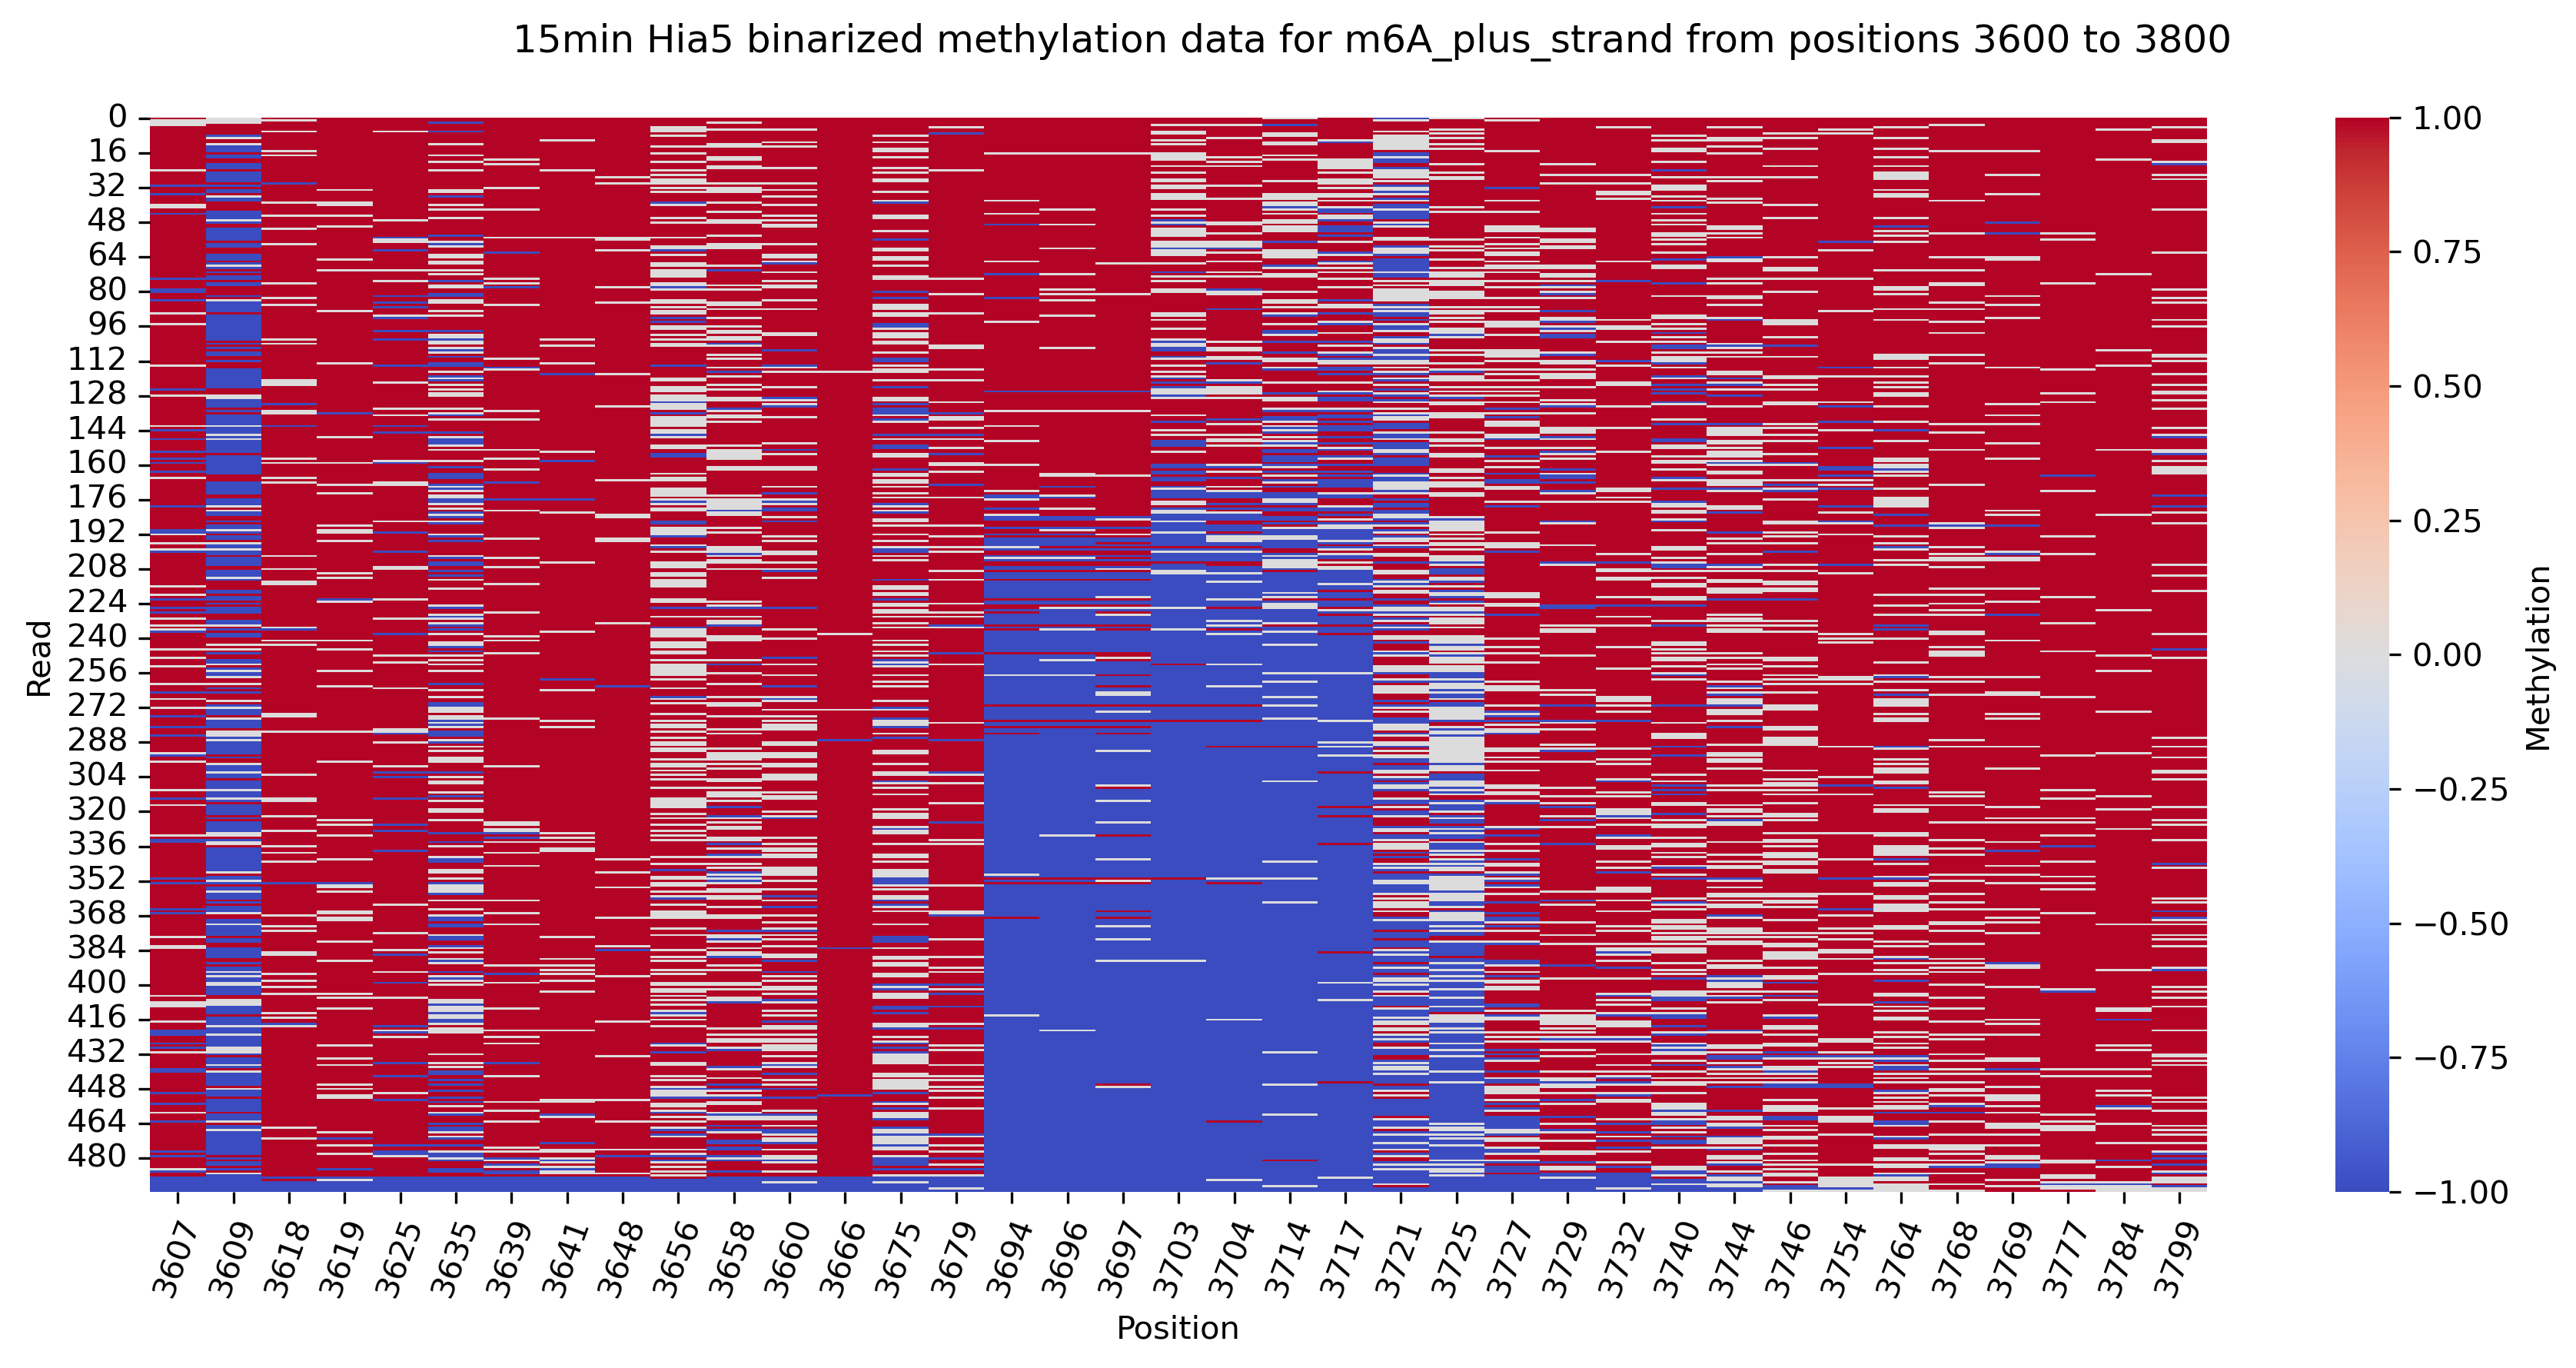

21:24:28: sorting m6A_plus_strand data for sample 30min Hia5
21:24:28: Plotting the sorted SMF data


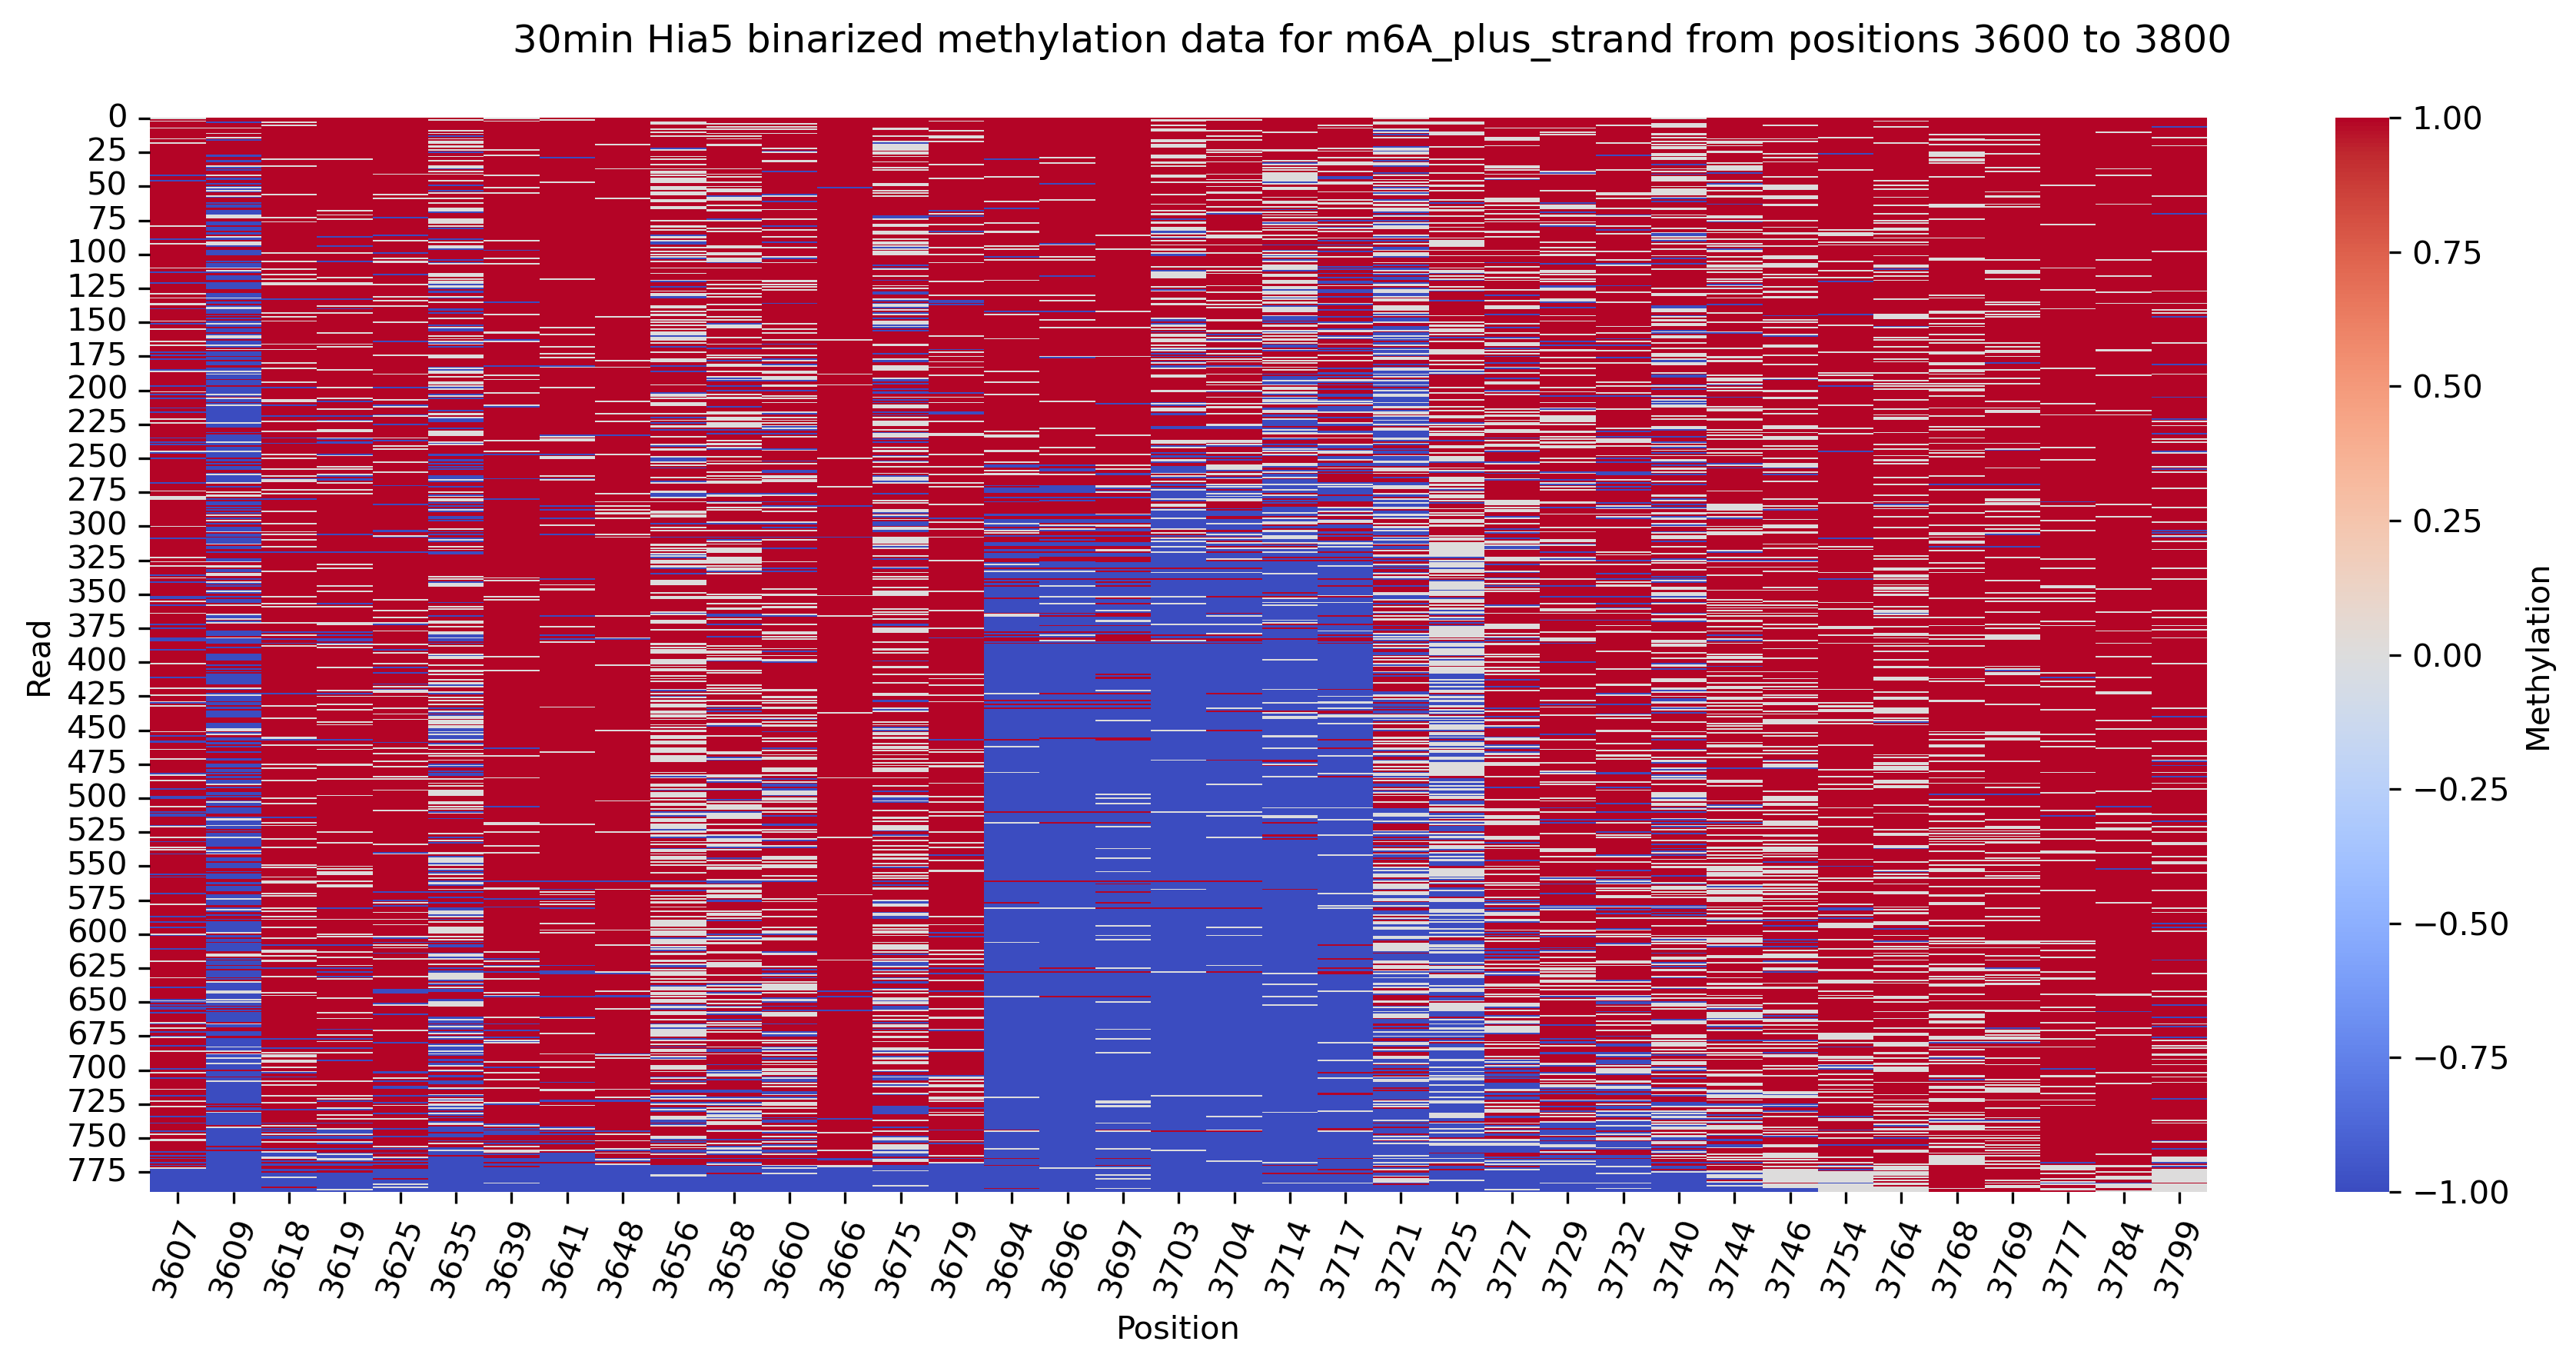

21:24:28: sorting m6A_plus_strand data for sample 30min No MTase
21:24:28: Plotting the sorted SMF data


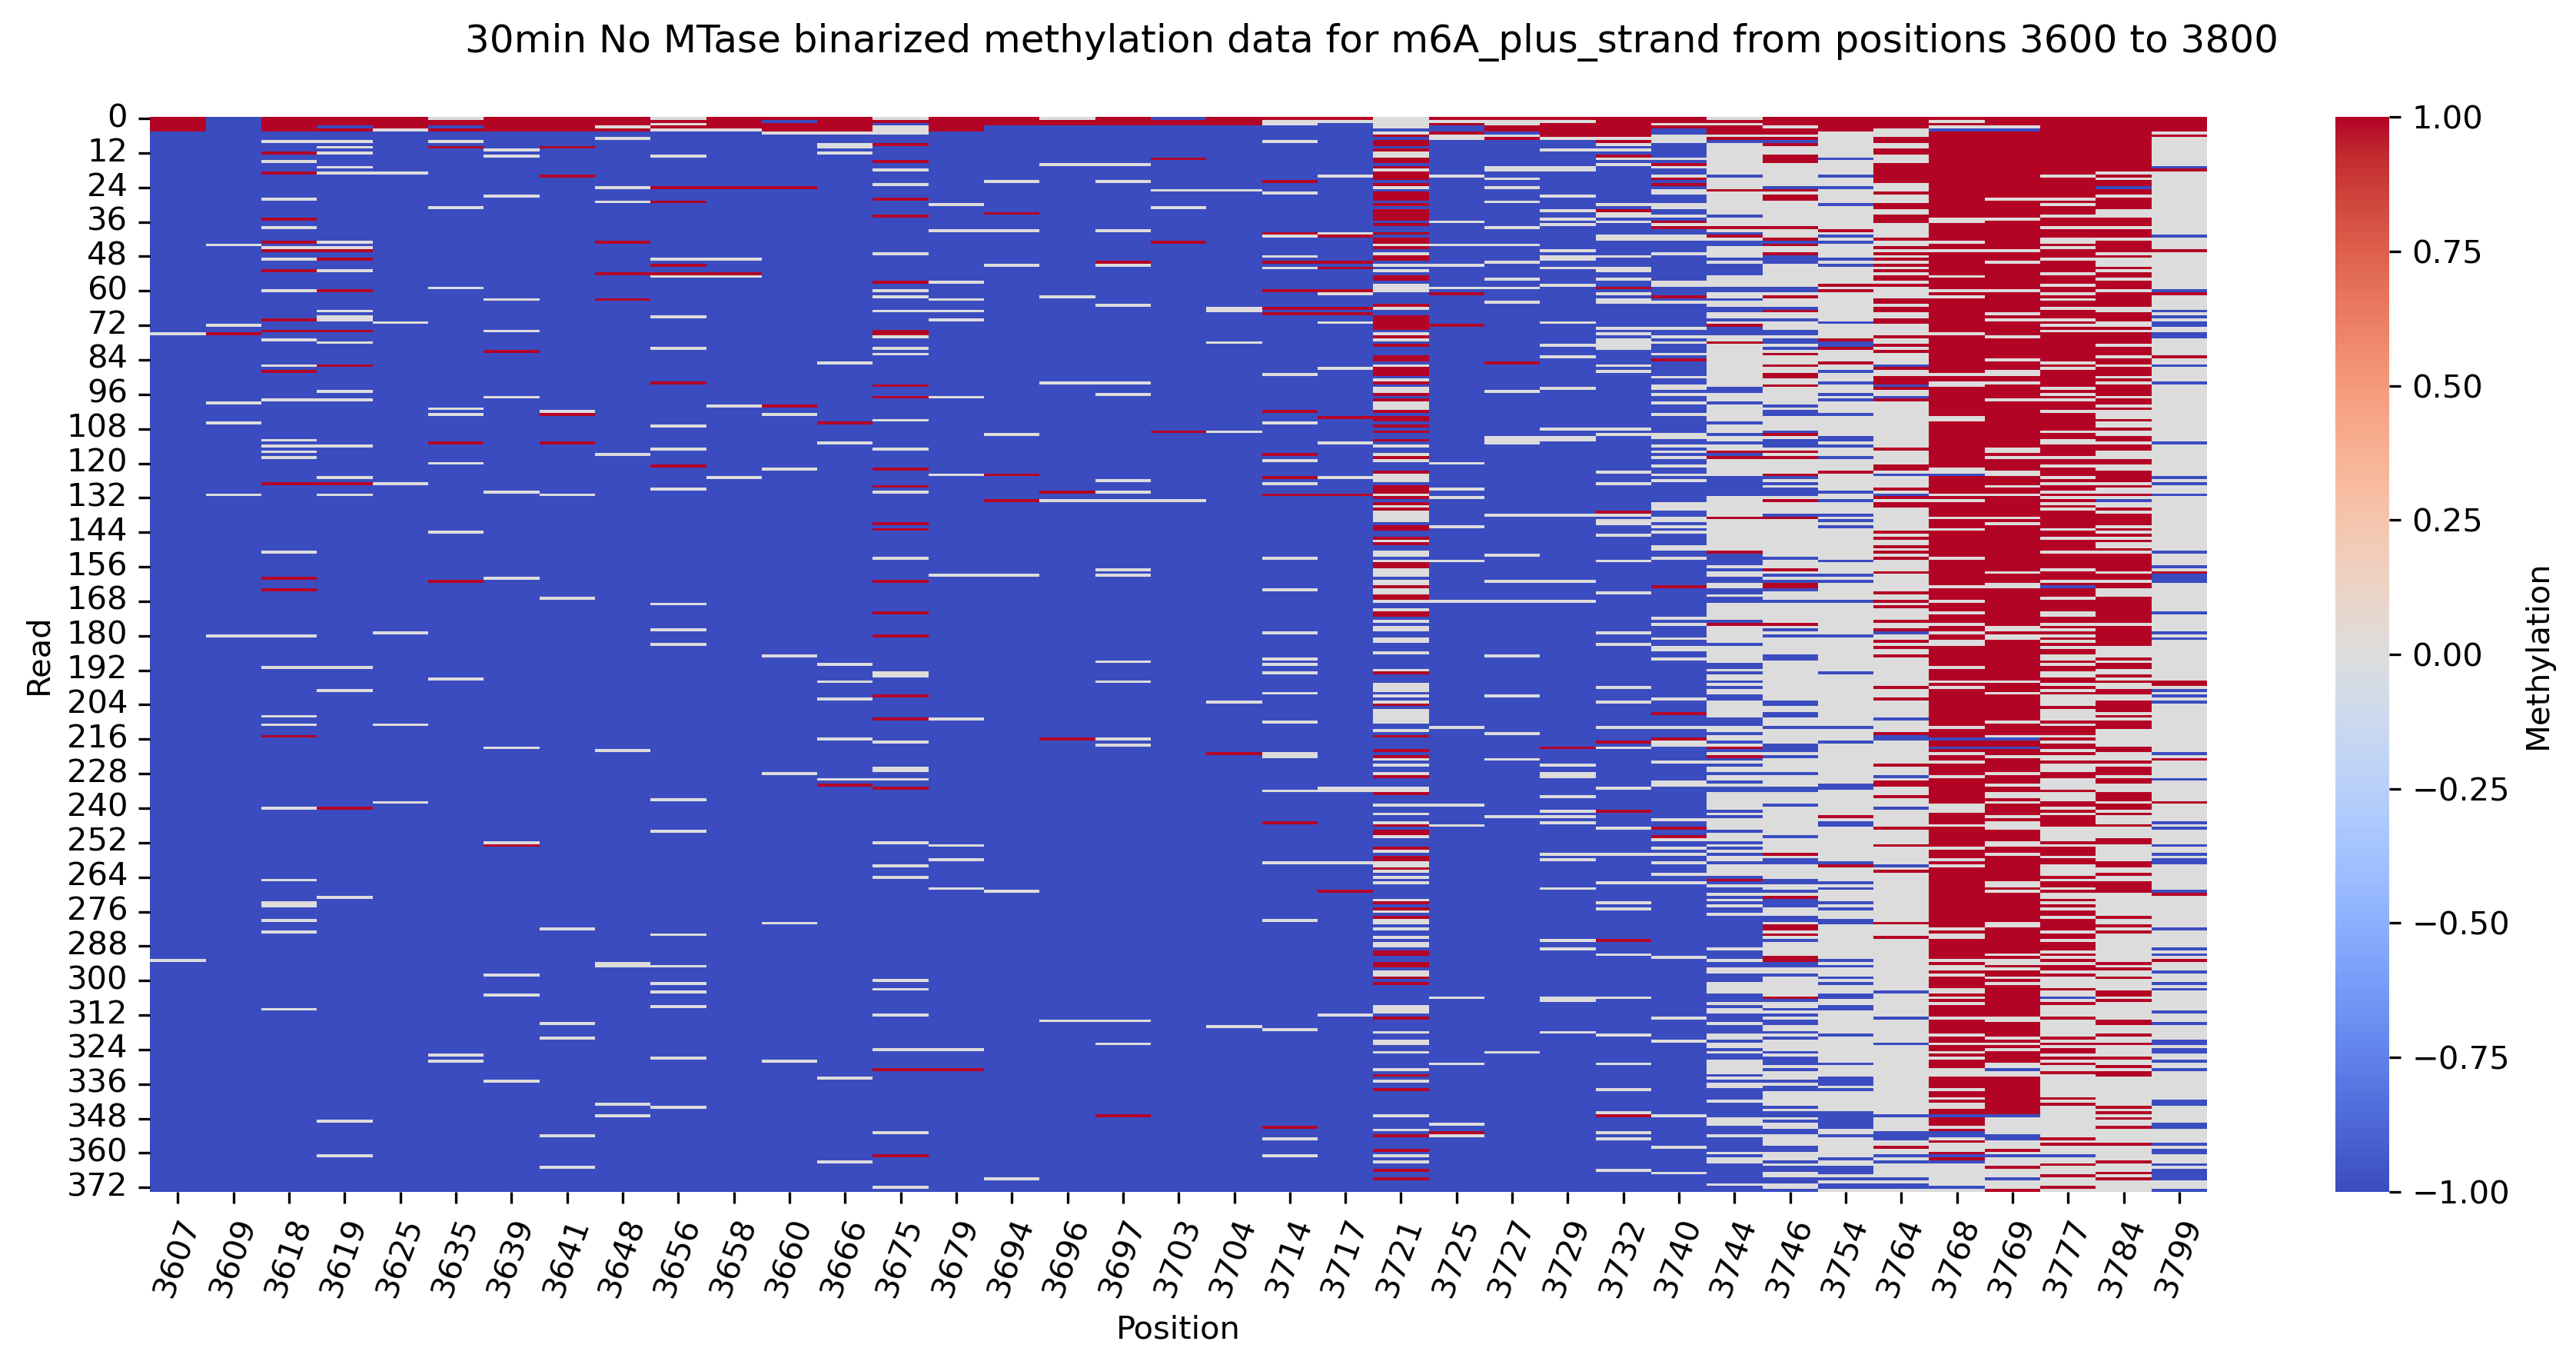

In [12]:
## Plotting a basic Read by position methylation heatmap that is sorted by read sum methylation intensity ##

## Parameters ##
show_basic_plot = True
save_basic_plot = False
pallet = 'coolwarm'
#################

if show_basic_plot:
# Plotting basic heatmap
    for dataset in adata_dict.keys():
        input_adata_name = f'{dataset}{adata_suffix}'
        input_adata = adata_dict[dataset][input_adata_name]
        sample_names = sample_dict[dataset]
        for j, sample in enumerate(sample_names):
            print('{0}: sorting {1} data for sample {2}'.format(time_string(), dataset, sample))
            temp_adata_subset = input_adata[input_adata.obs['Sample_names'] == str(sample)]
            df = adata_to_df(temp_adata_subset)
            df['row_sum'] = df.sum(axis=1)
            # Sort the DataFrame by the row sums in descending order
            df_sorted = df.sort_values(by='row_sum', ascending=False)
            # Drop the temporary 'row_sum' column
            df_sorted = df_sorted.drop(columns=['row_sum'])
            df_sorted = df_sorted.reset_index(drop=True)
            # Create heatmap
            title = '{0} binarized methylation data for {1} from positions {2} to {3}'.format(sample, dataset, lower_bound, upper_bound)
            cmap = pallet
            xlabel = 'Position'
            ylabel = 'Read'
            colorbar_label = 'Methylation'
            save_name = cwd + '/{0}_{1} sorted binarized methylation data for {2} {3}_{4}'.format(date_string, sample, dataset, lower_bound, upper_bound)
            print('{0}: Plotting the sorted SMF data'.format(time_string()))
            pair_heatmap_plot(df_sorted, title, xlabel, ylabel, save_basic_plot, save_name, cmap, colorbar_label)

21:24:29: Calculating kmeans clustering of adata_subset for 3 clusters
21:24:29: sorting m6A_plus_strand data for sample 15min Hia5
21:24:29: Sorting data on kmeans_labels_reordered observation
21:24:29: Plotting the k-means cluster sorted SMF data


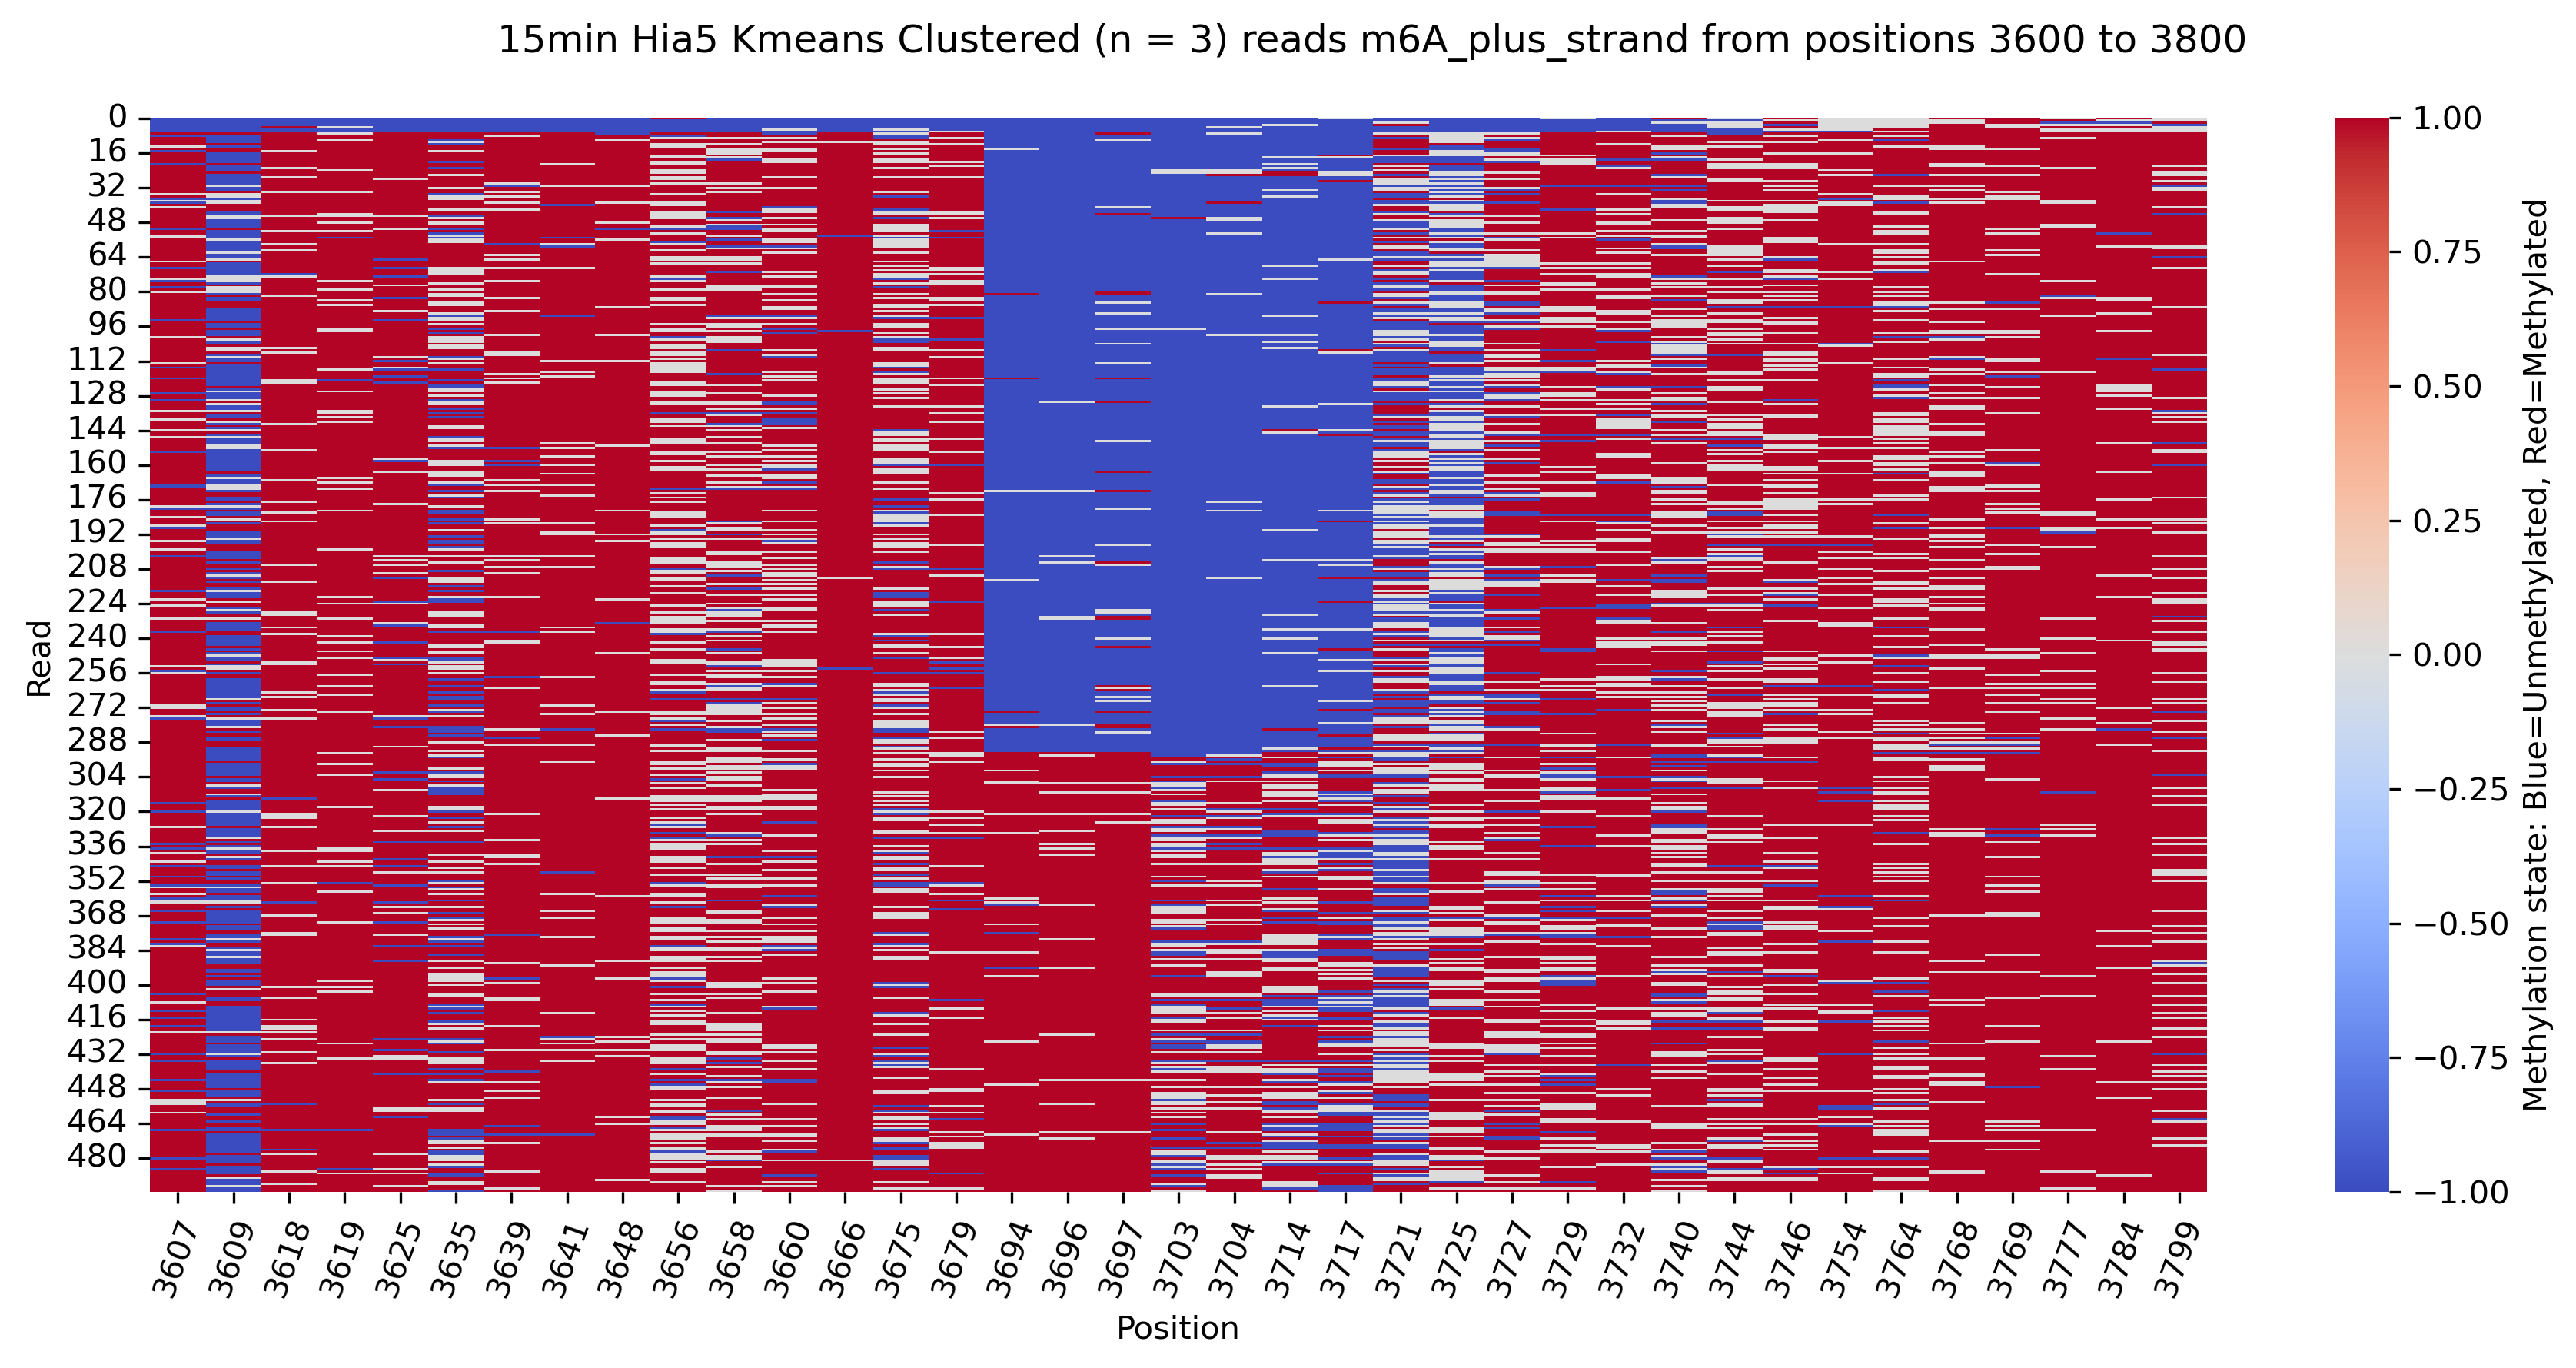

21:24:30: sorting m6A_plus_strand data for sample 30min Hia5
21:24:30: Sorting data on kmeans_labels_reordered observation
21:24:30: Plotting the k-means cluster sorted SMF data


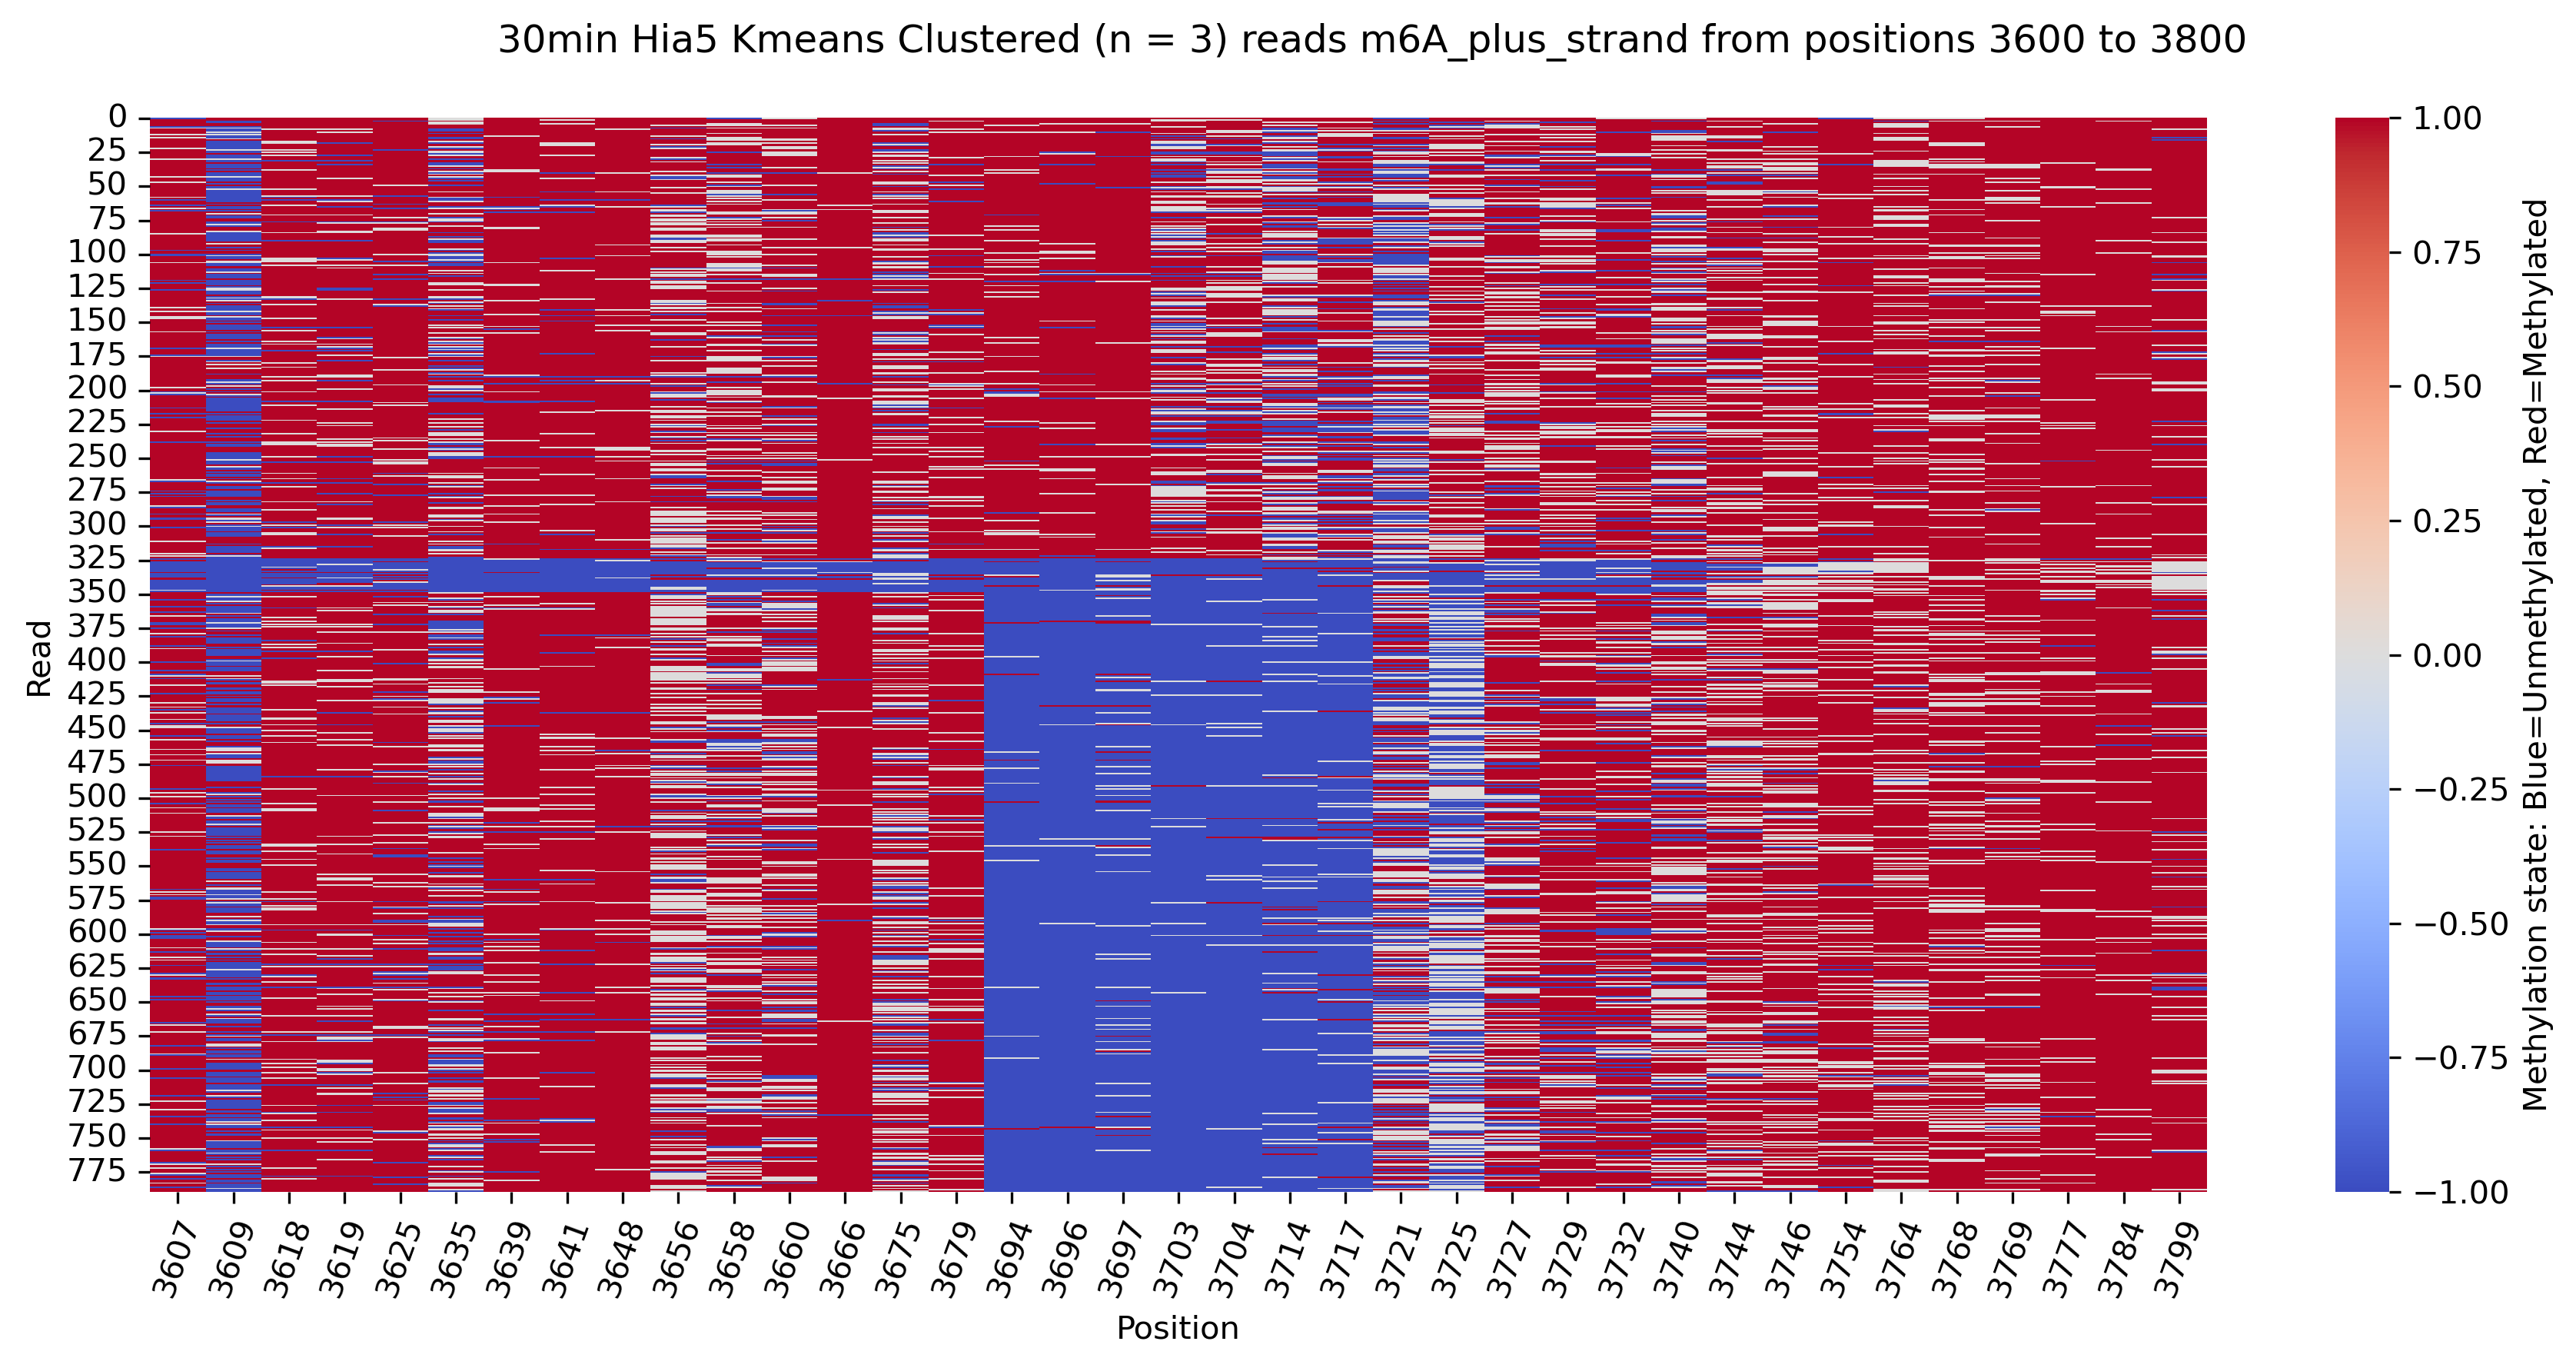

21:24:30: sorting m6A_plus_strand data for sample 30min No MTase
21:24:30: Sorting data on kmeans_labels_reordered observation
21:24:30: Plotting the k-means cluster sorted SMF data


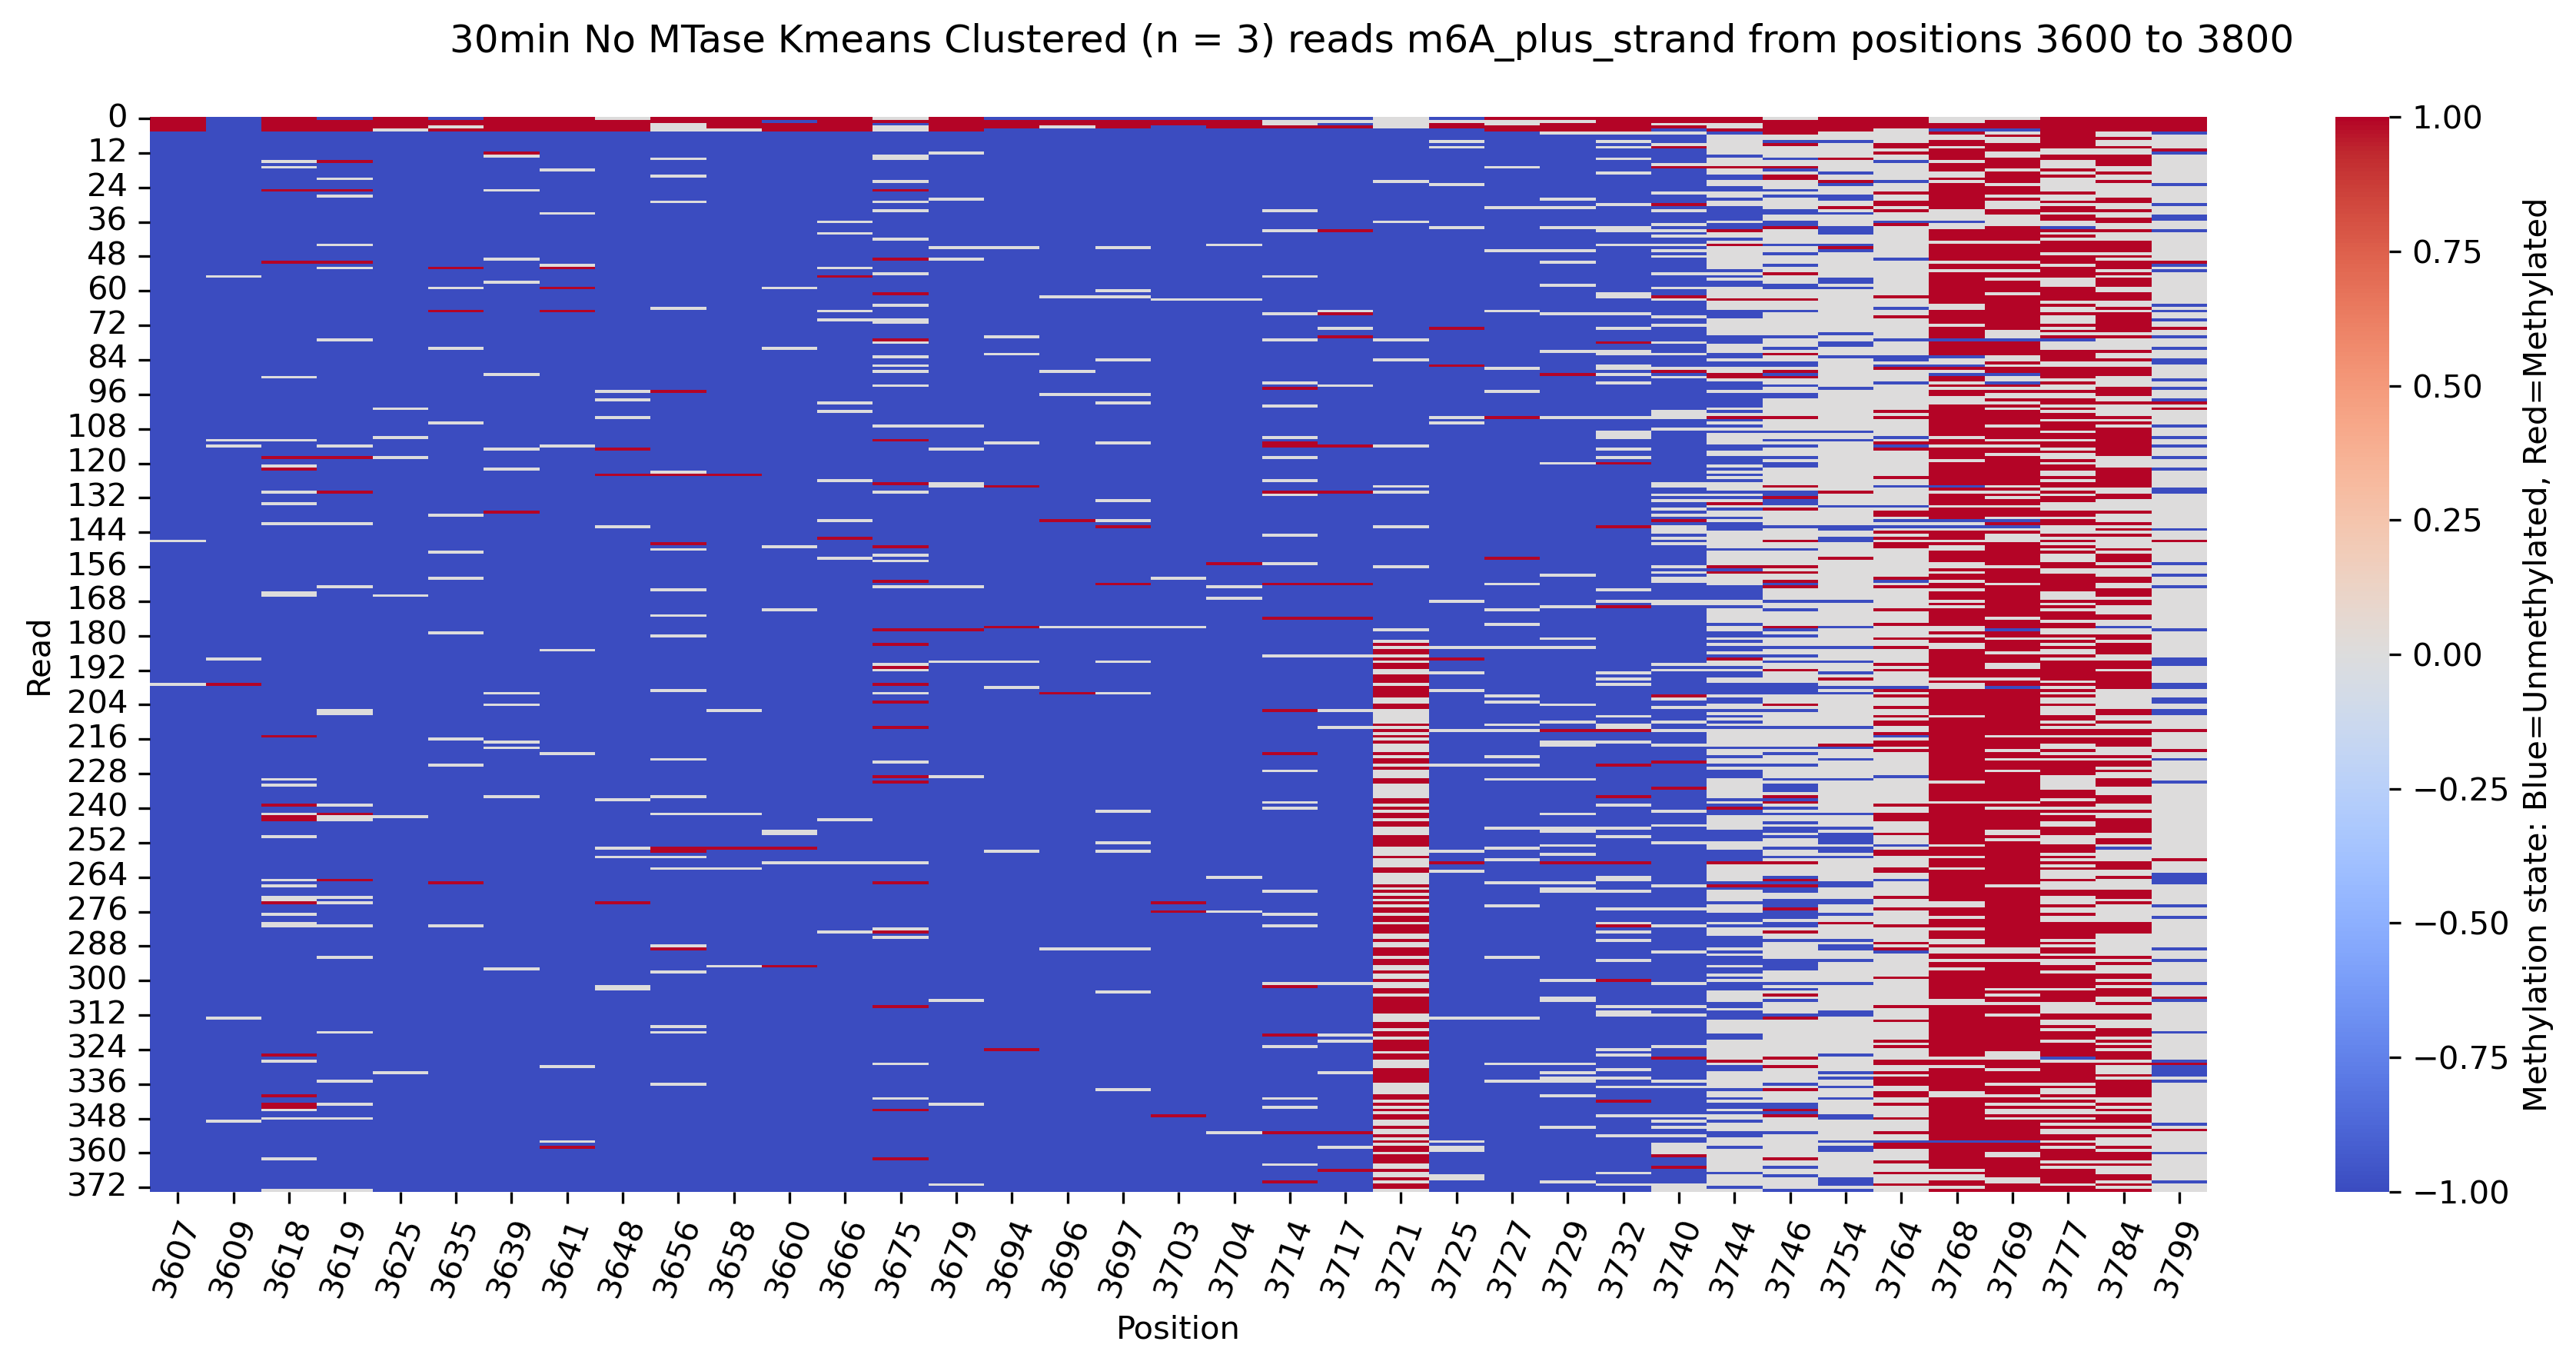

In [13]:
## Plotting a k means clustered Read by position methylation heatmap that is sorted by read sum methylation intensity ##

## Parameters ##
n_kmeans_clusters = 3
show_kmeans_plot = True
save_kmeans_plot = False
pallet = 'coolwarm'
#################

if show_kmeans_plot:
    from sklearn.cluster import KMeans
    # Create a KMeans object with the desired number of clusters
    print('{0}: Calculating kmeans clustering of adata_subset for {1} clusters'.format(time_string(), n_kmeans_clusters))
    kmeans = KMeans(n_clusters=n_kmeans_clusters)
    for dataset in adata_dict.keys():
        input_adata_name = f'{dataset}{adata_suffix}'
        input_adata = adata_dict[dataset][input_adata_name]
        sample_names = sample_dict[dataset]
        for j, sample in enumerate(sample_names):
            print('{0}: sorting {1} data for sample {2}'.format(time_string(), dataset, sample))
            adata_subset = input_adata[input_adata.obs['Sample_names'] == str(sample)].copy()    
            # Fit the KMeans model to the data
            kmeans.fit(adata_subset.X)
            # Get the cluster labels for each data point
            cluster_labels = kmeans.labels_
            # Add the kmeans cluster data as an observation to the anndata object
            adata_subset.obs['kmeans_labels'] = cluster_labels.astype(str)
            # Calculate the mean of each observation categoty of each cluster
            cluster_means = adata_subset.obs.groupby('kmeans_labels').mean()
            # Sort the cluster indices by mean methylation value
            sorted_clusters = cluster_means.sort_values(by='mean_methylation', ascending=False).index
            # Create a mapping of the old cluster values to the new cluster values
            sorted_cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
            # Apply the mapping to create a new observation value: kmeans_labels_reordered
            adata_subset.obs['kmeans_labels_reordered'] = adata_subset.obs['kmeans_labels'].map(sorted_cluster_mapping)
            adata_subset.obs['kmeans_labels_reordered'] = adata_subset.obs['kmeans_labels_reordered'].astype(int)
            # Sort the adata_subset object by the kmeans_labels_reordered observation
            print('{0}: Sorting data on kmeans_labels_reordered observation'.format(time_string()))
            sorted_indices = adata_subset.obs.sort_values(by='kmeans_labels_reordered').index
            adata_subset = adata_subset[sorted_indices].copy()
            #adata_subset.obs = adata_subset.obs.sort_values(by='kmeans_labels_reordered')
            df = adata_to_df(adata_subset)
            df = df.reset_index(drop=True)
            # Create heatmap
            title = '{0} Kmeans Clustered (n = {1}) reads {2} from positions {3} to {4}'.format(sample, n_kmeans_clusters ,dataset, lower_bound, upper_bound)
            cmap = 'coolwarm'  #'Blues'
            xlabel = 'Position'
            ylabel = 'Read'
            colorbar_label = 'Methylation state: Blue=Unmethylated, Red=Methylated'
            save_name = cwd + '/{0}_{1}_{2} clustered binarized methylation data for {3} {4}_{5}'.format(date_string, time_string(sep=''), sample, dataset, lower_bound, upper_bound)
            print('{0}: Plotting the k-means cluster sorted SMF data'.format(time_string()))
            pair_heatmap_plot(df, title, xlabel, ylabel, save_kmeans_plot, save_name, cmap, colorbar_label)

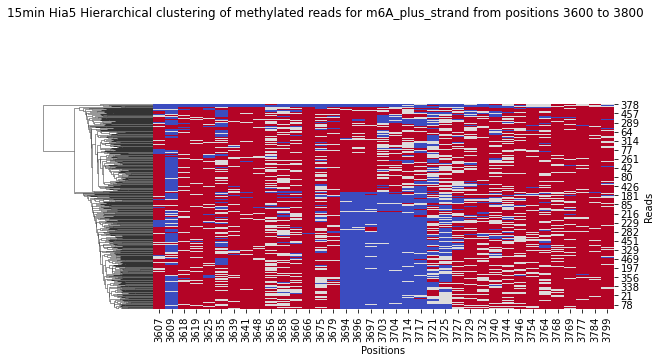

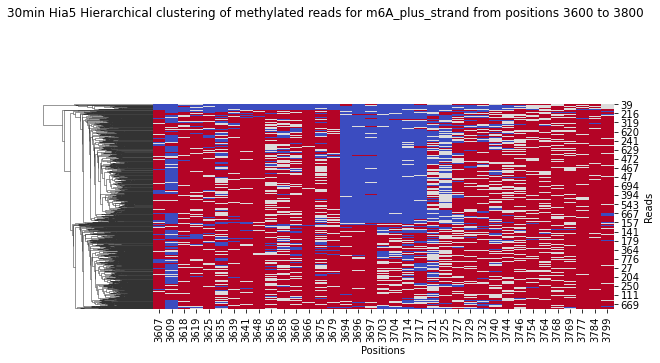

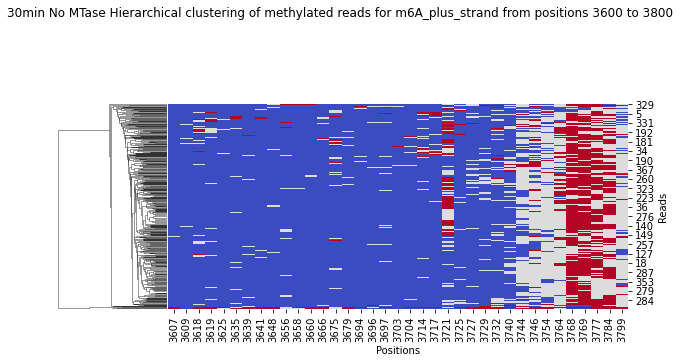

In [14]:
## Plotting a Hierarchical clustered Read by position methylation heatmap ##

## Parameters ##
show_hierchical_plot = True 
save_hierarchical_plot = False
pallet = 'coolwarm'
#################

if show_hierchical_plot:
    from scipy.cluster.hierarchy import linkage, dendrogram
    for dataset in adata_dict.keys():
        input_adata_name = f'{dataset}{adata_suffix}'
        input_adata = adata_dict[dataset][input_adata_name]
        sample_names = sample_dict[dataset]
        for j, sample in enumerate(sample_names):
            temp_adata_subset = input_adata[input_adata.obs['Sample_names'] == str(sample)]
            df = adata_to_df(temp_adata_subset)
            df = df.reset_index(drop=True)
            clustergrid = sns.clustermap(df, cmap=pallet, method='average', metric='euclidean', row_cluster=True, col_cluster=False, figsize=(10, 6), cbar=(False))
            clustergrid.fig.suptitle('{0} Hierarchical clustering of methylated reads for {1} from positions {2} to {3}'.format(sample_names[j], dataset, lower_bound, upper_bound), y=0.9)
            clustergrid.ax_heatmap.set_xlabel('Positions')
            clustergrid.ax_heatmap.set_ylabel('Reads')
            plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)   
            if clustergrid.cax is not None:
                clustergrid.cax.set_visible(False)         
            if save_hierarchical_plot:
                save_name=cwd + '/{0}_{1} Hierarchical heatmap for {2} {3}_{4}'.format(date_string, sample_names[j],  dataset, lower_bound, upper_bound)
                clustergrid.savefig(save_name, bbox_inches='tight', pad_inches=0.1)
            else:
                plt.show()

21:24:34: Calculating combination matrix


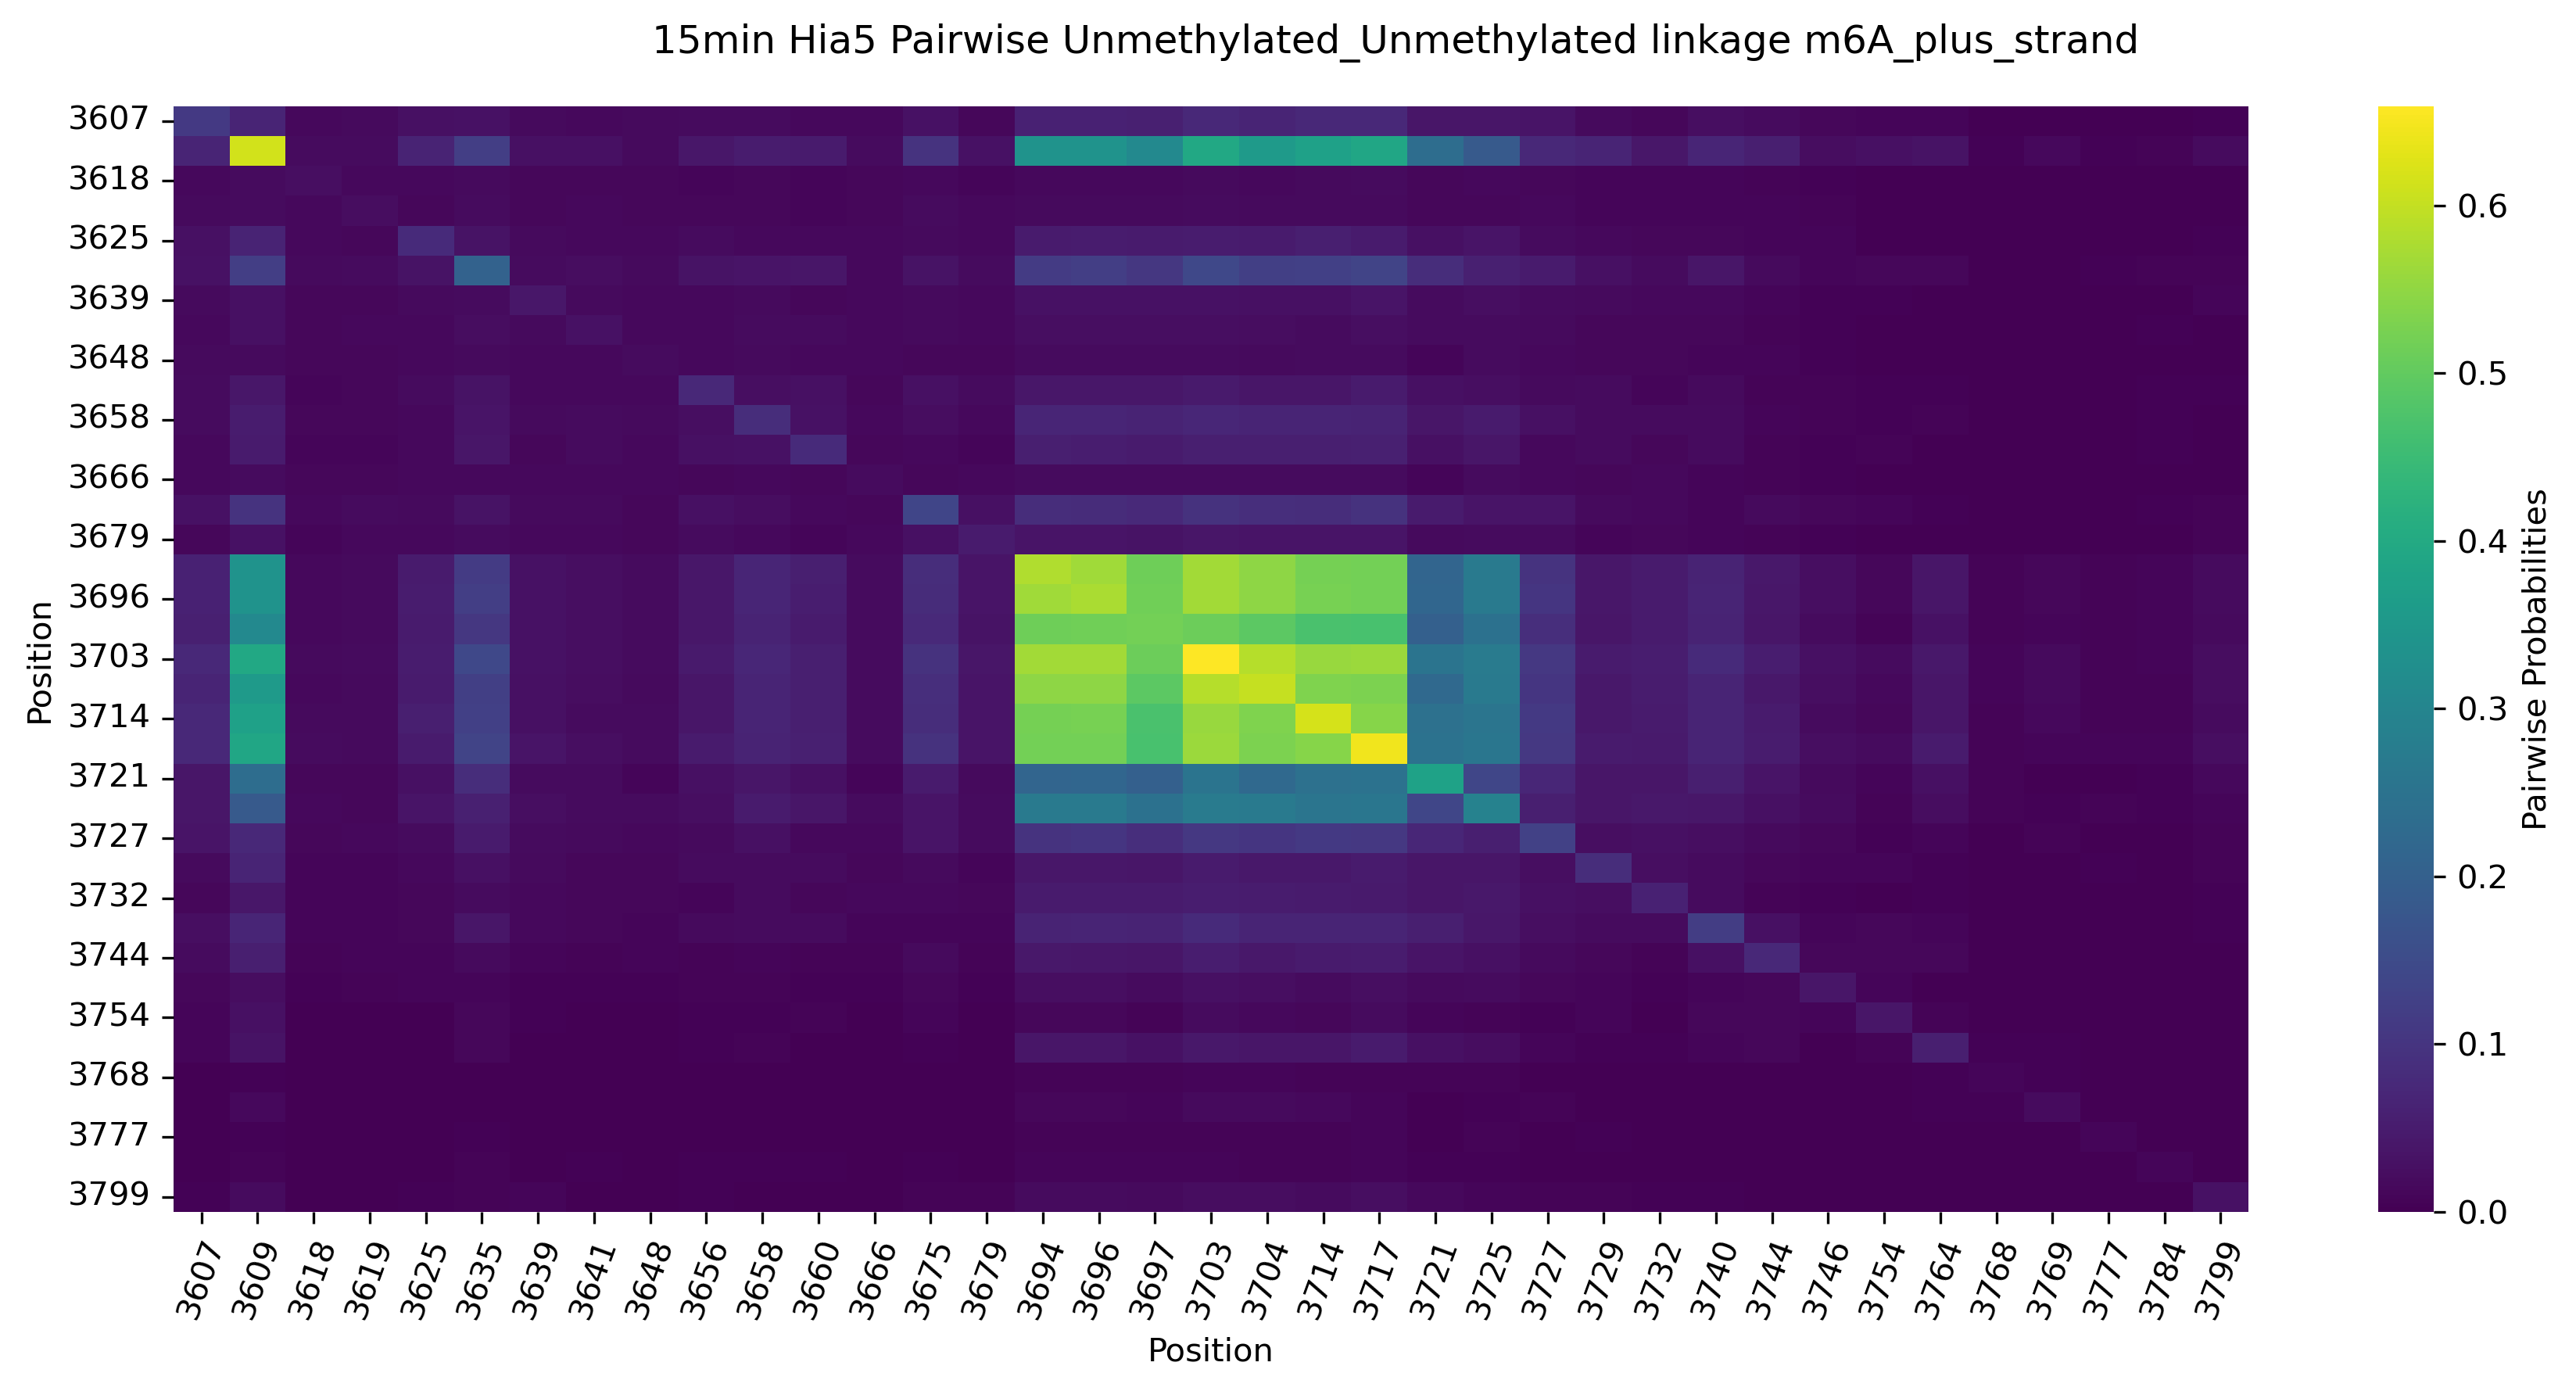

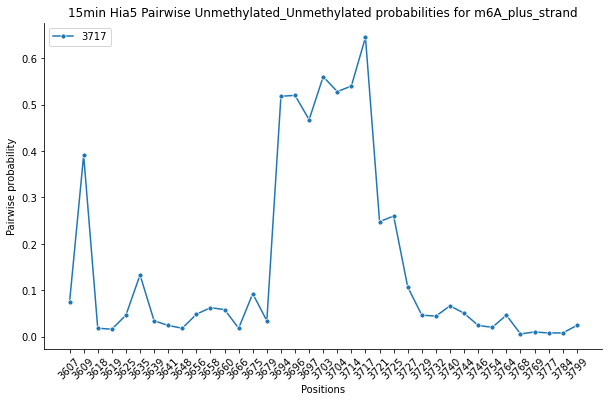

21:24:34: Calculating combination matrix


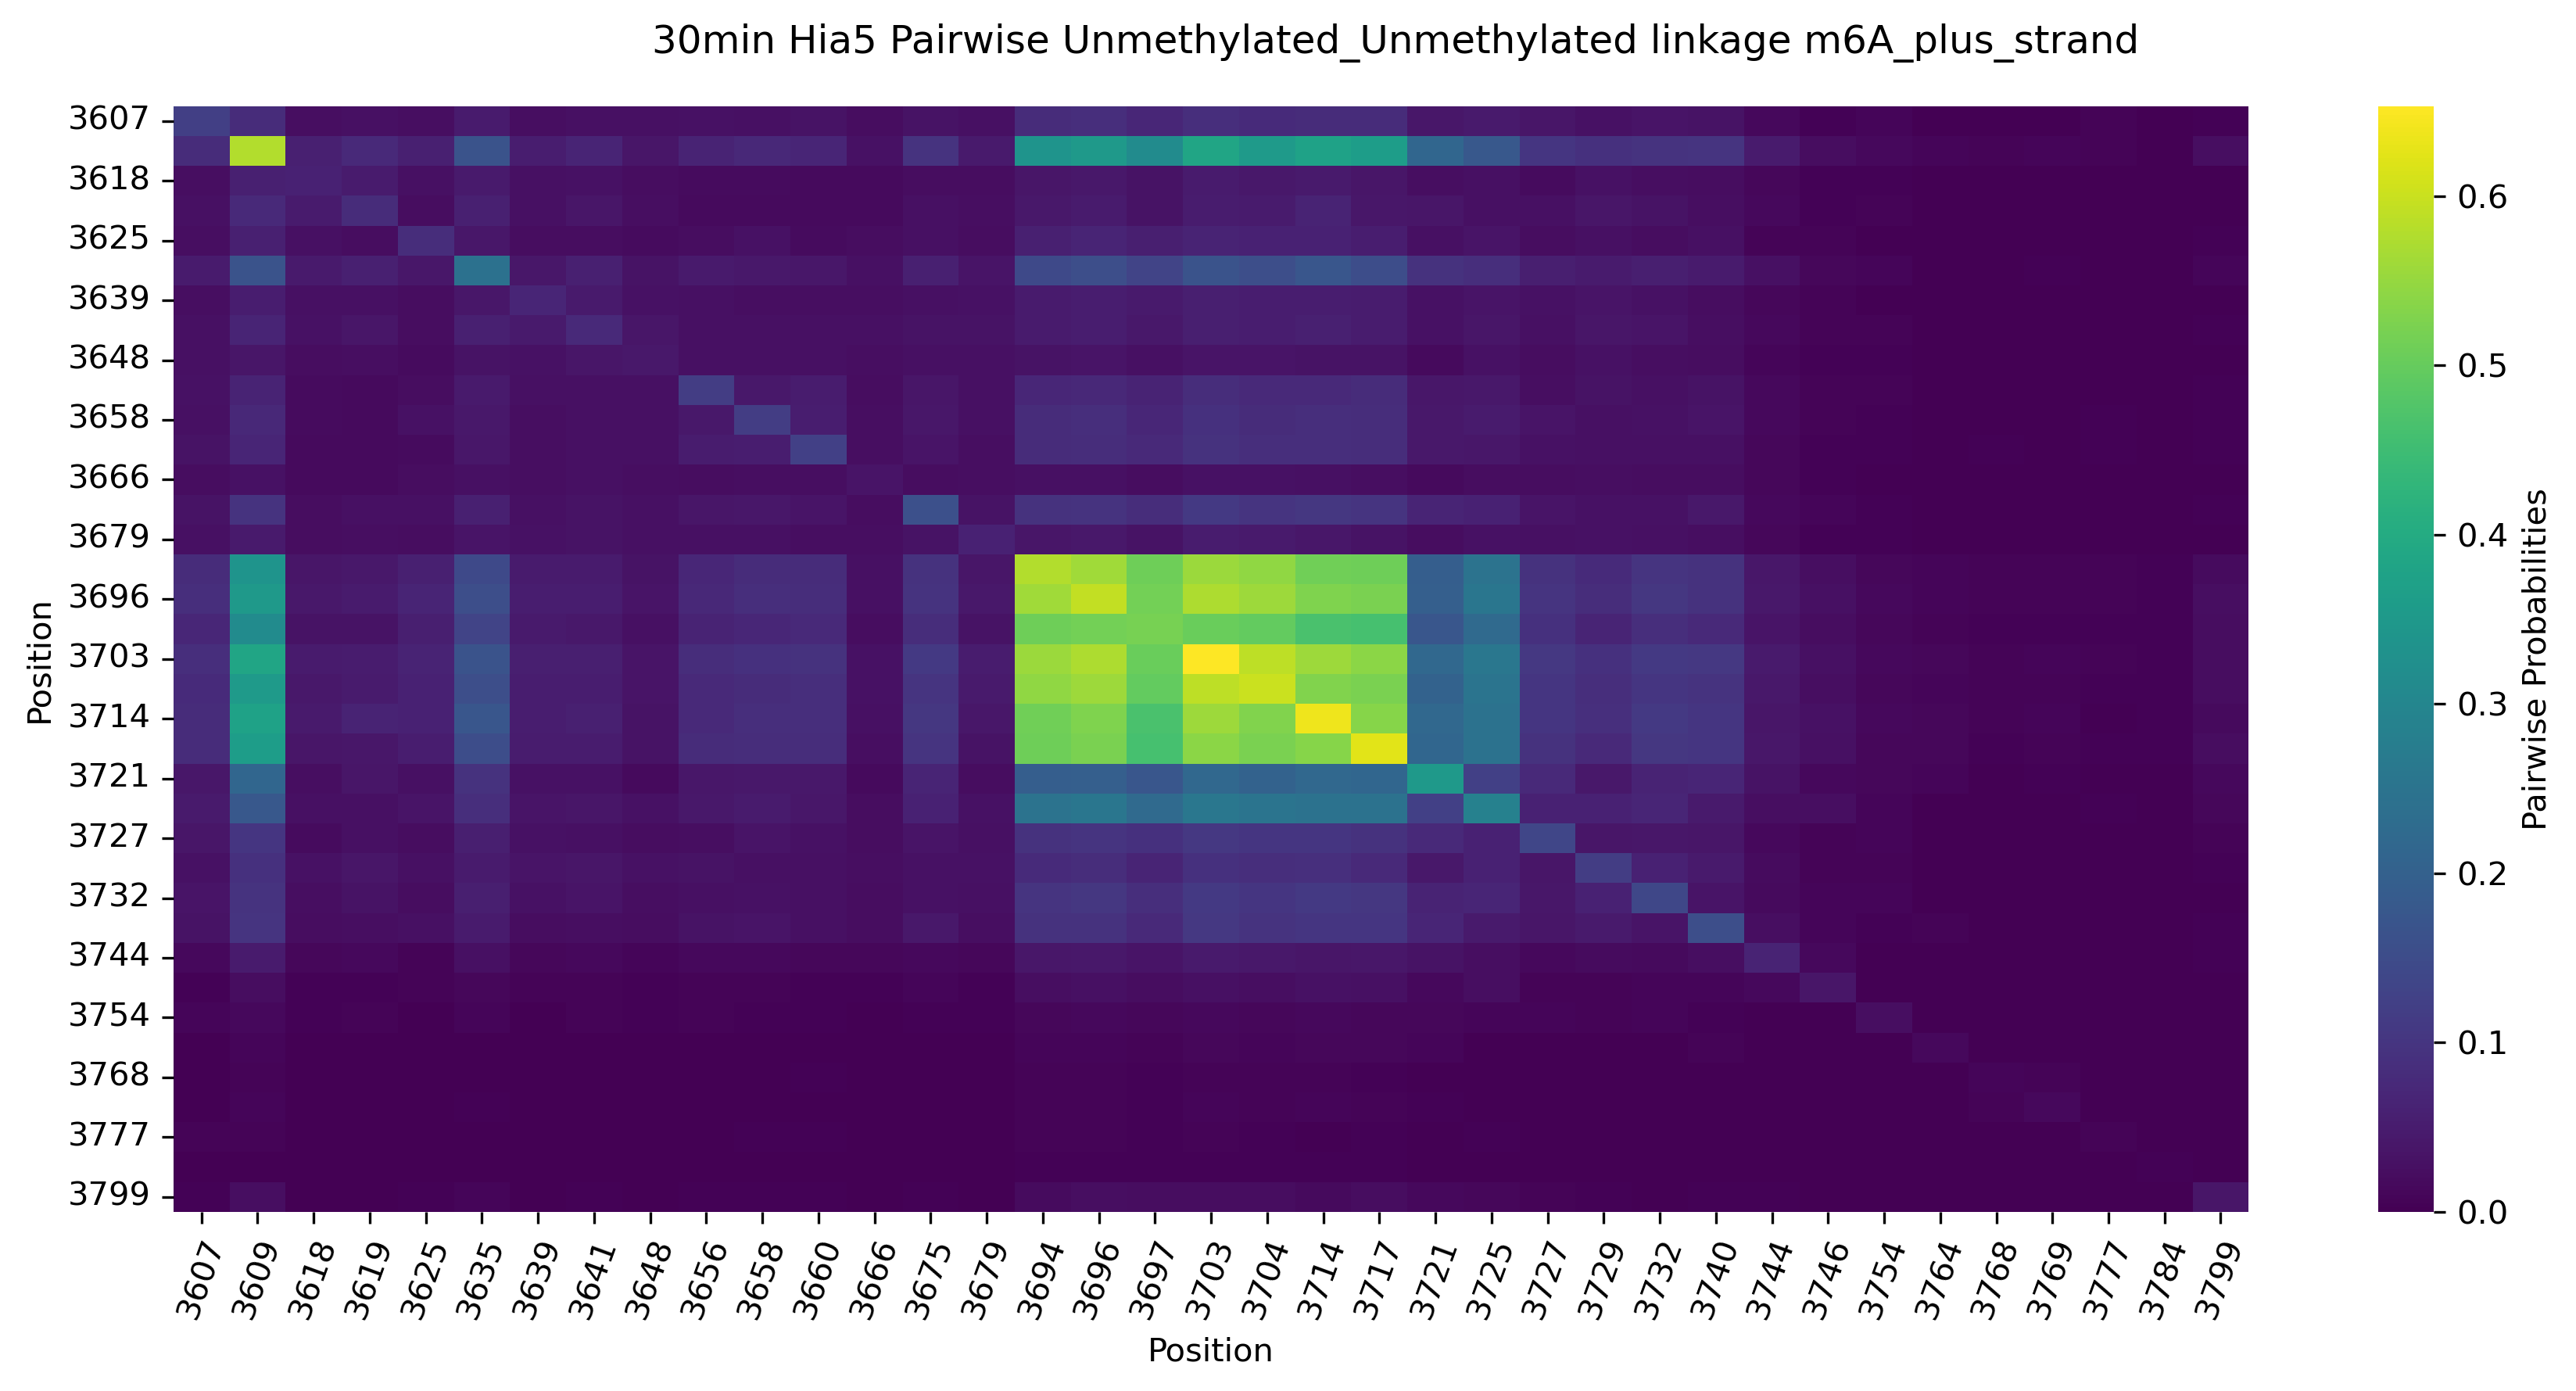

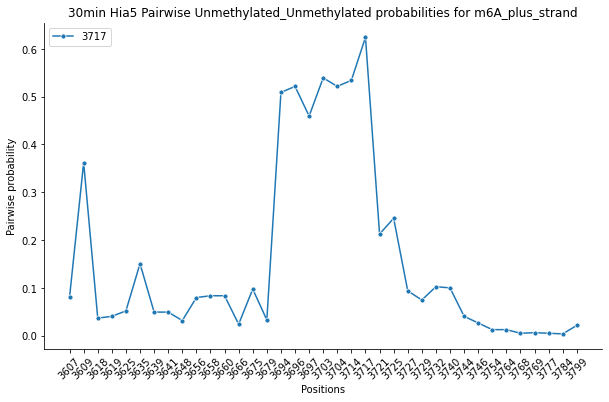

21:24:35: Calculating combination matrix


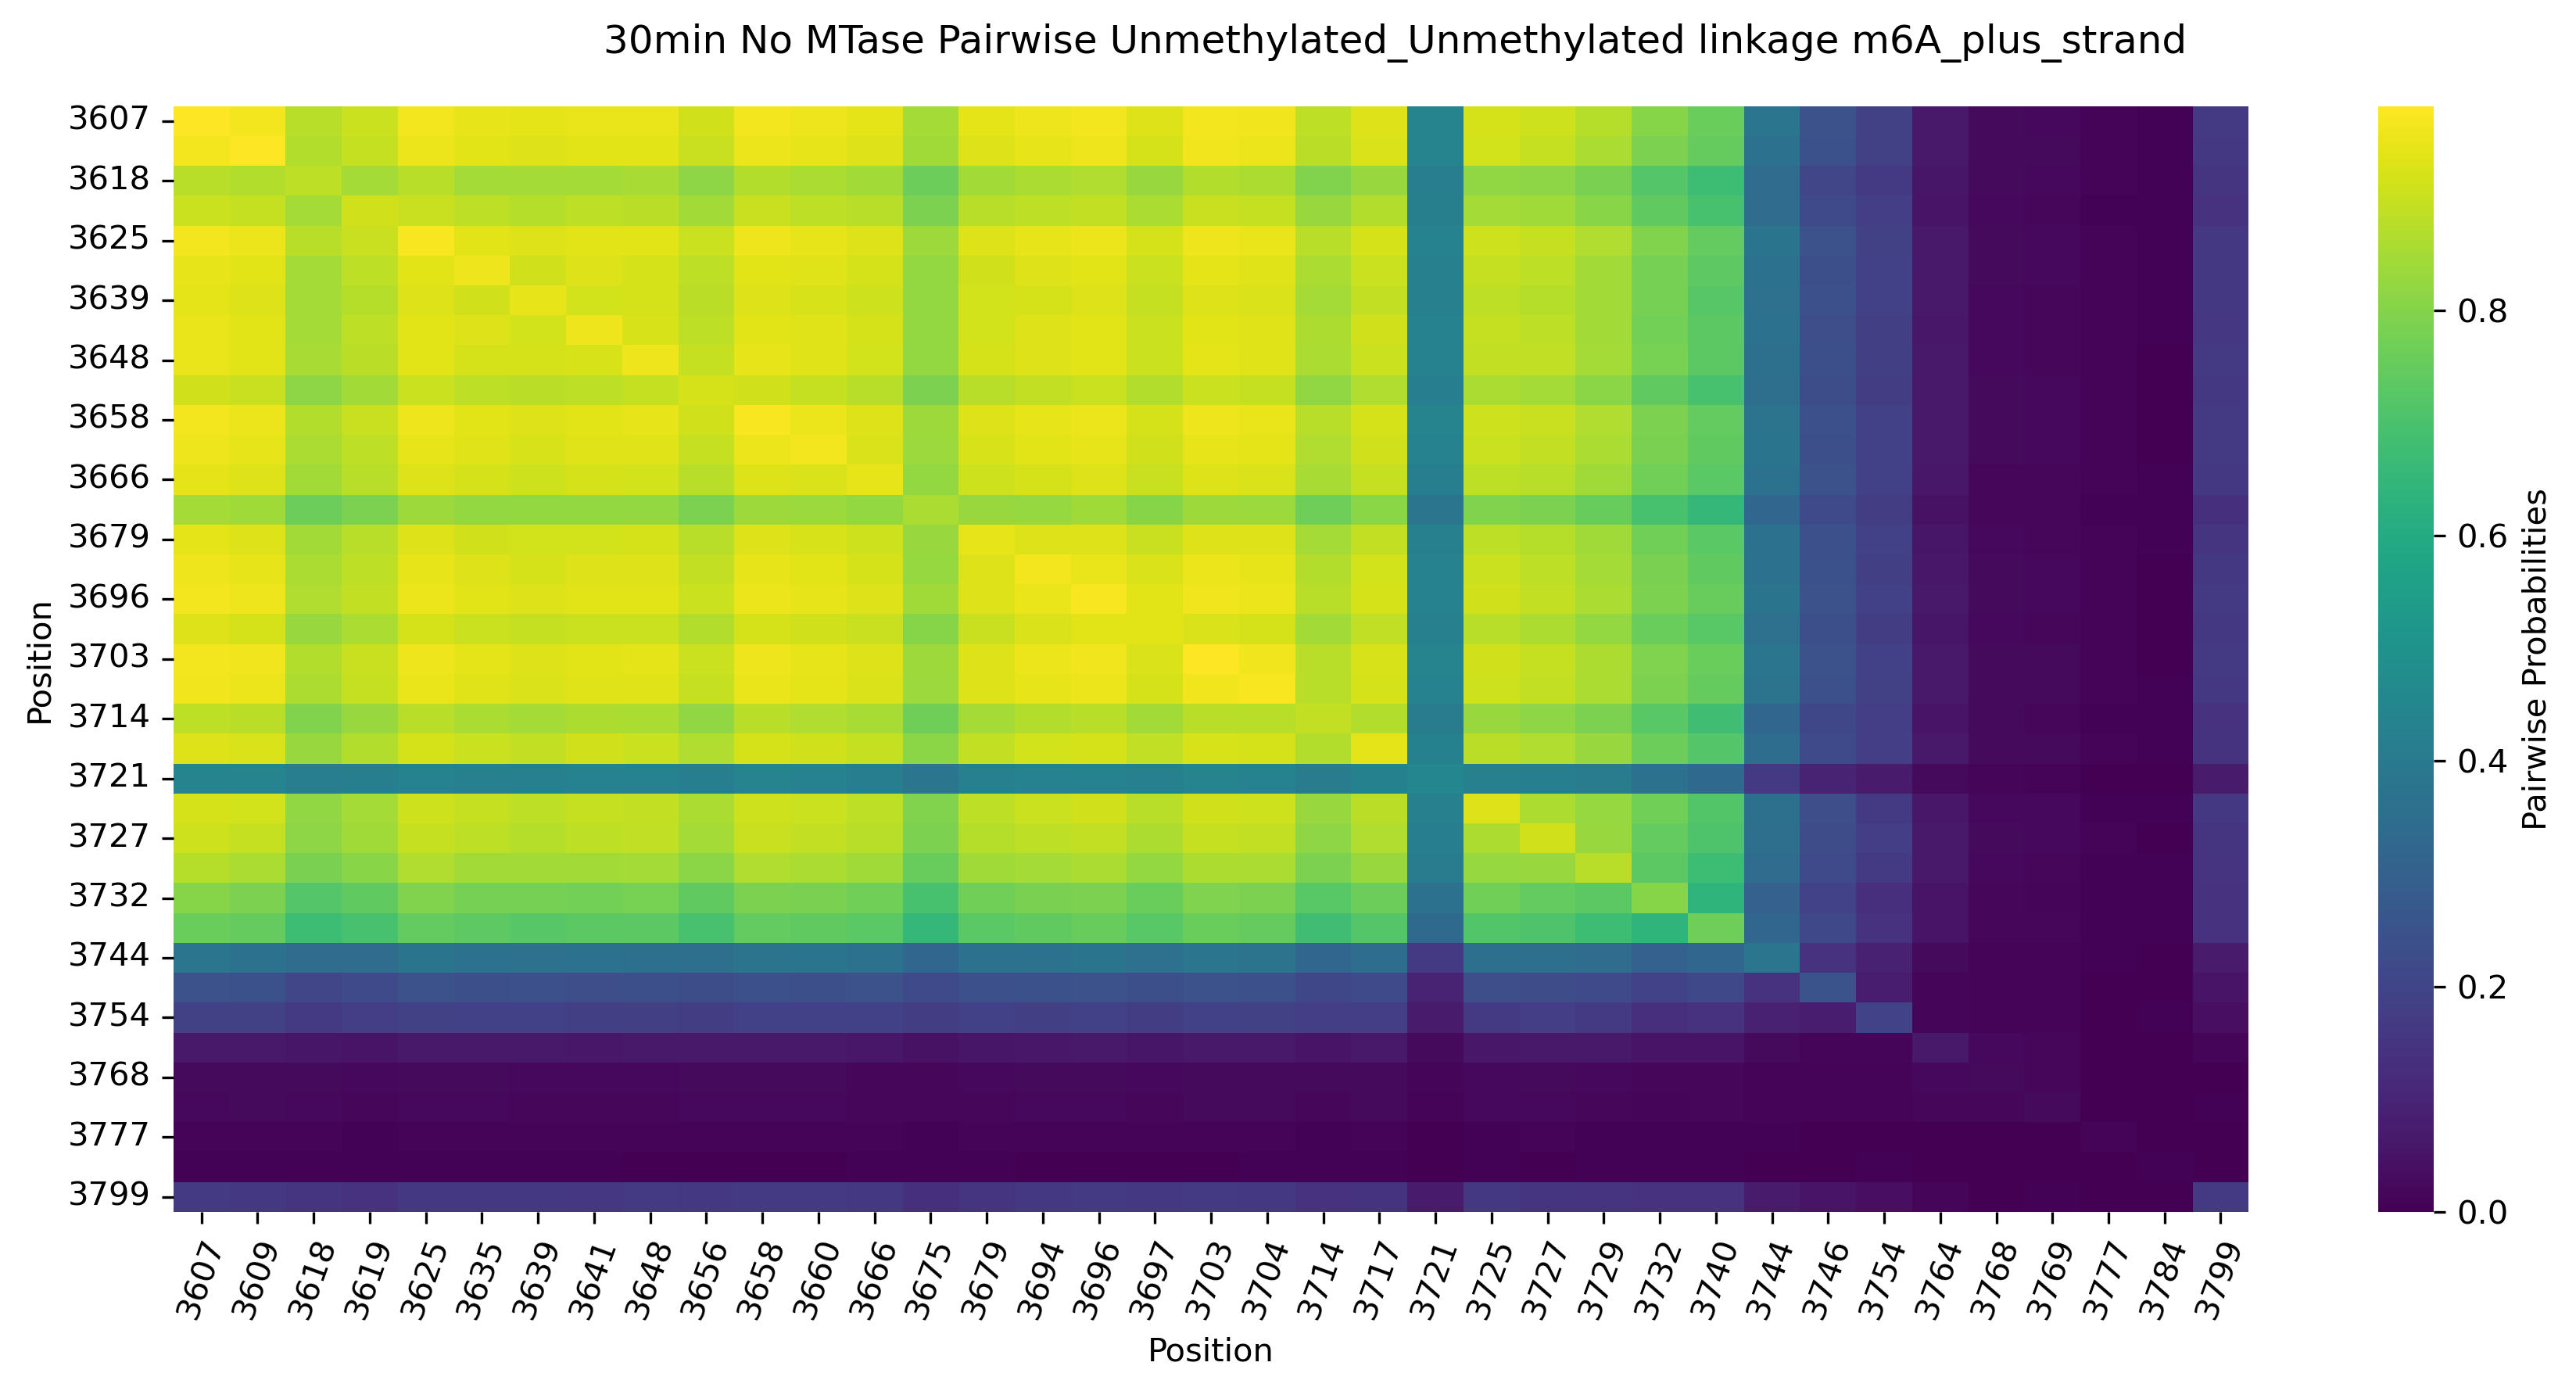

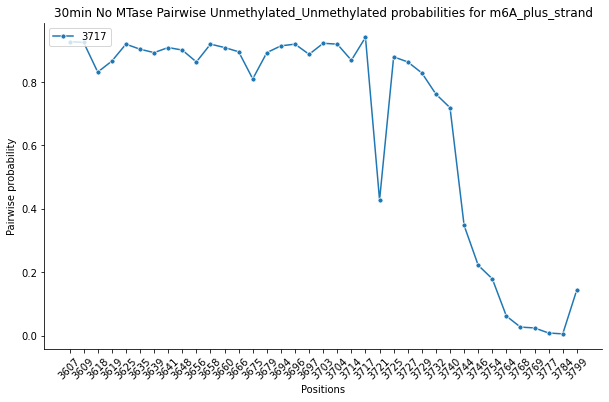

In [15]:
## Plotting Combinations heatmap of position by position for a specific pairwise methlation state ##

## Parameters ##
# pairwise_vmax_value = 1.1 # Maximal pairwise value to use in the pairwise heatmap colorbar
show_pairwise_combinations_plot = True
save_pairwise_combinations_plot = False
plot_pairwise_single_position = True
pairwise_positions_to_plot = ['3717']
save_pairwise_single_position = False
interaction= ['1-1','1-0','0-1','0-0'] # Pairwise combination interactions
pairwise_combinations = 3 # Index of the pairwise combination to analyze
adata_suffix = '_subset_filtered'
pallet = 'viridis'
#################

if show_pairwise_combinations_plot:
    for dataset in adata_dict.keys():
        input_adata_name = f'{dataset}{adata_suffix}'
        input_adata = adata_dict[dataset][input_adata_name]
        sample_names = sample_dict[dataset]
        for j, sample in enumerate(sample_names):
            temp_adata_subset = input_adata[input_adata.obs['Sample_names'] == str(sample)]
            df = adata_to_df(temp_adata_subset)
            df = df.reset_index(drop=True)
            result_matrix = calculate_combinations_matrix_numpy(df)
            result_matrix_single = result_matrix[:,:,pairwise_combinations]
            result_df = pd.DataFrame(result_matrix_single)
            result_df.columns = df.columns
            result_df = result_df.set_index(df.columns)
            interaction_II = ['Methylated_Methylated', 'Methylated_Unmethylated', 'Unmethylated_Methylated', 'Unmethylated_Unmethylated']
            xlabel = 'Position'
            ylabel = 'Position'
            colorbar_label = 'Pairwise Probabilities' # On diagnal is the probability of a square being in the first state. Off the diagnal is pairwise probability
            title = '{0} Pairwise {1} linkage {2}'.format(sample, interaction_II[pairwise_combinations], dataset)
            save_name = cwd + '/{0}_{1} Pairwise {2} linkage {3} {4}_{5}'.format(date_string, sample, interaction_II[pairwise_combinations], dataset, lower_bound, upper_bound)
            pair_heatmap_plot(result_df, title, xlabel, ylabel, save_pairwise_combinations_plot, save_name, cmap=pallet, colorbar_label=colorbar_label)
            if plot_pairwise_single_position:
                plt.figure(figsize=(10, 6))
                plt.title(f'{sample} Pairwise {interaction_II[pairwise_combinations]} probabilities for {dataset}')
                #plt.ylim(-0.05, 1)  # Adjust y-axis limits
                for position in pairwise_positions_to_plot:
                    if position in result_df.index:
                        row_to_plot = result_df.loc[position]
                        # Plot the selected row
                        row_df = pd.DataFrame({'Positions': row_to_plot.index, 'Pairwise probability': row_to_plot.values})
                        ax = sns.lineplot(data=row_df, x='Positions', y='Pairwise probability', marker='o', markersize=5, label=f'{position}')
                        num_ticks = 20  # Number of x-ticks you want to display
                        tick_positions = range(0, len(row_df), len(row_df) // num_ticks)  # Calculate tick positions
                        tick_labels = row_df['Positions'][::len(row_df) // num_ticks]  # Get labels for tick positions
                        ax.set_xticks(tick_positions)
                        ax.set_xticklabels(tick_labels, rotation=45)  # Rotate labels if necessary
                        ax.spines['right'].set_visible(False)
                        ax.spines['top'].set_visible(False)
                        ax.legend(loc='upper left')
                if save_pairwise_single_position:
                    save_name = cwd + '/{0}_{1} Pairwise {2} probability plot for {3} {4}_{5}'.format(date_string, sample, interaction_II[pairwise_combinations], dataset, lower_bound, upper_bound)
                    plt.savefig(save_name)
                else:
                    plt.show()

In [20]:
df = adata_to_df(adata)
old_value, new_value = [1, 2]
df = df.replace(old_value, new_value)
old_value, new_value = [np.nan, 1]
df = df.replace(old_value, new_value)
adata.X = df.values 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7


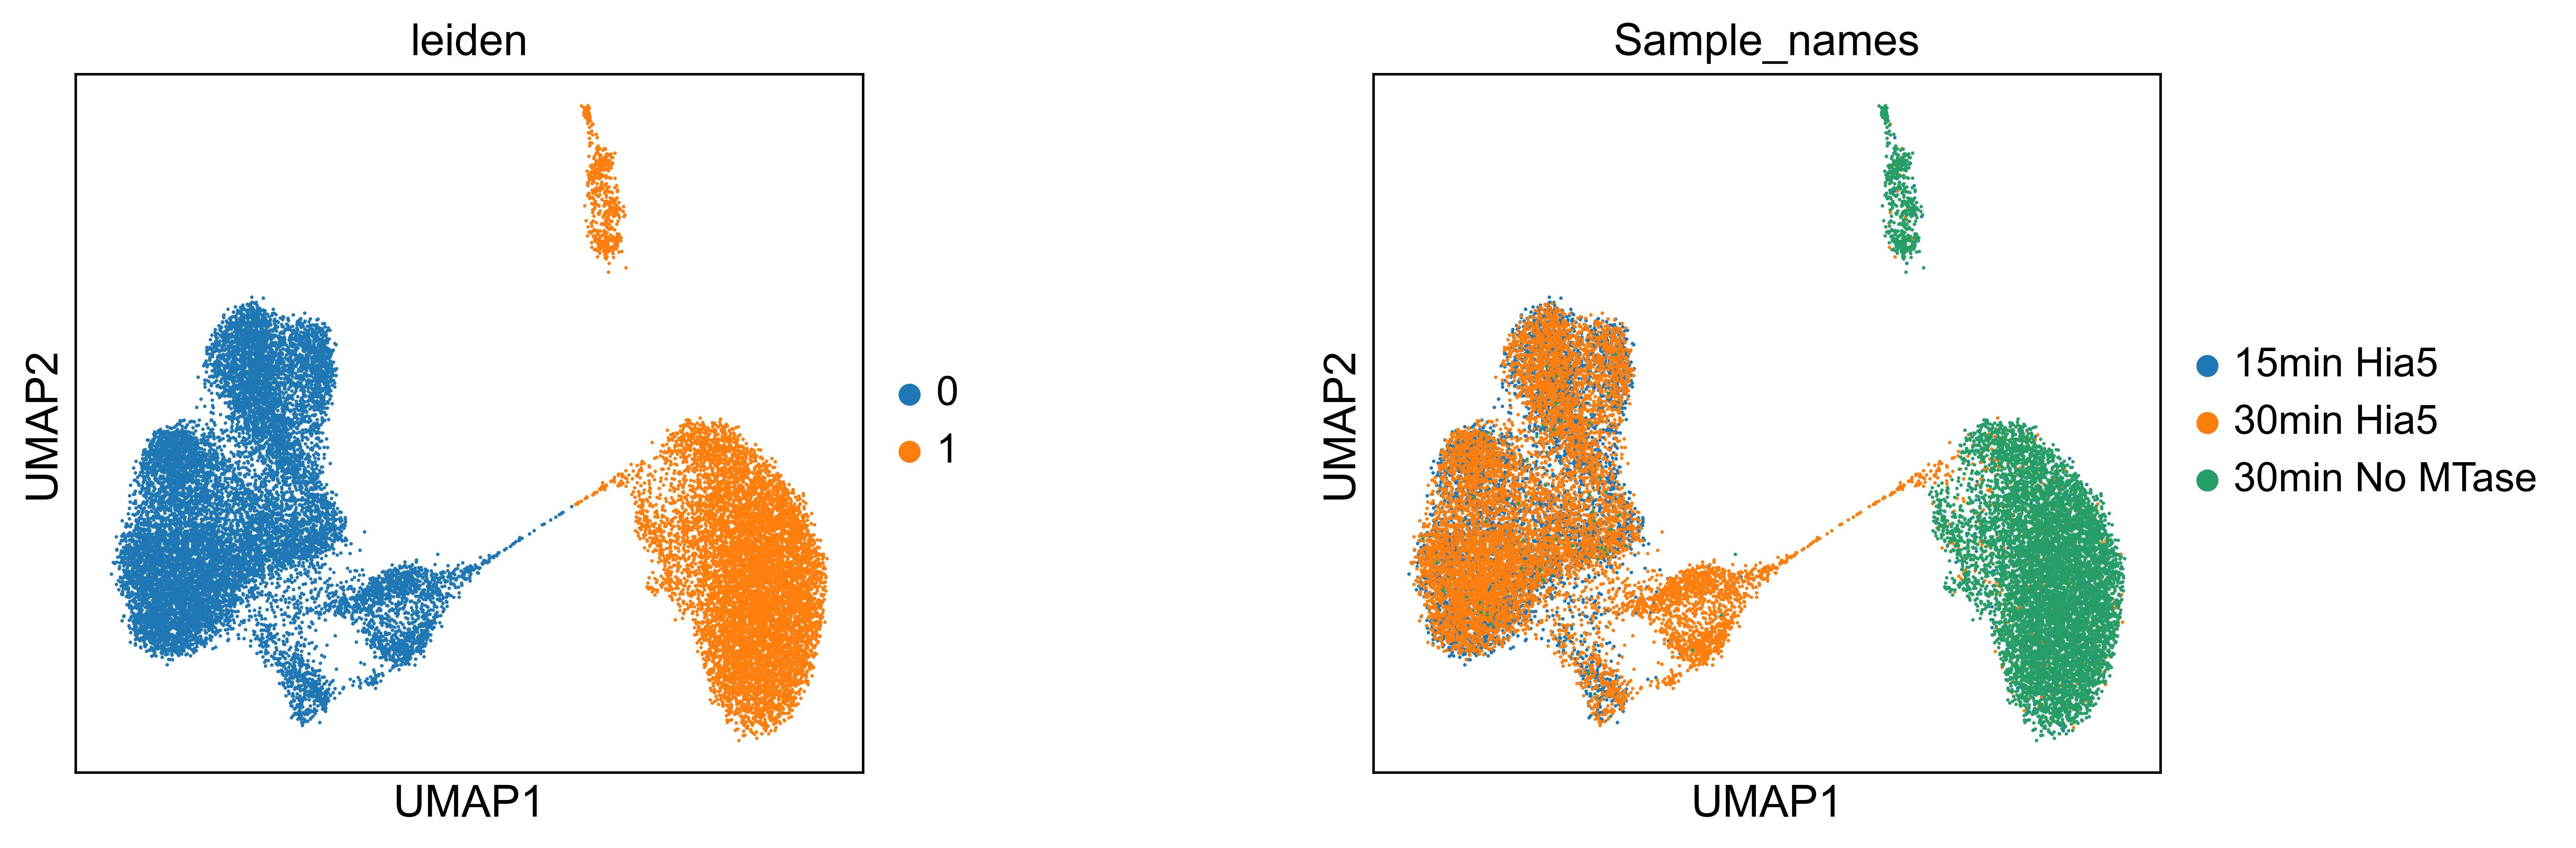

In [21]:
## Plotting higher dimensional analyses u ##

## Parameters ##
# pairwise_vmax_value = 1.1 # Maximal pairwise value to use in the pairwise heatmap colorbar
show_scanpy_plots = True
save_scanpy_plots = False
umap_obs_to_plot = ['leiden', 'Sample_names']
n_neighbors = 30 # Number of neighbors for the neighborhood graph
leiden_resolution = 0.02 # Resolution value for leiden clustering. Higher value generates more clusters
adata_suffix = '_subset_filtered_methylation_filtered'
#################

if show_scanpy_plots:
    import scanpy as sc
    # set scanpy parameters
    sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_header()
    sc.settings.set_figure_params(dpi=300, facecolor='white')

    # Calculate QC metrics     
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True) # Calculates QC metrics

    ## Scale the data and perform PCA ##
    sc.pp.scale(adata)
    sc.tl.pca(adata, svd_solver='arpack')
    #sc.pl.pca_scatter(adata_subset)

    ## compute the neighborhood graph of cells using the PCA representation of the data matrix ##
    n_pcs = 20
    if len(adata.var) < n_pcs:
        n_pcs = len(adata.var) // 2
    if len(adata.obs) < n_neighbors*2:
        n_neighbors = len(adata.obs) // 2
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep='X_pca')

    ## Leiden graph-clustering method ##
    sc.tl.leiden(adata, resolution=leiden_resolution)

    ## Compute UMAP ##
    sc.tl.umap(adata)
    if save_scanpy_plots:
        save_name = cwd + '/{0}_{1} UMAP {2} {3} {4}_{5}'.format(date_string, sample_names[j], interaction_II[pairwise_combinations], dataset, lower_bound, upper_bound)
        sc.pl.umap(adata, color=umap_obs_to_plot, wspace=0.5, save=save_name)
    else: 
        sc.pl.umap(adata, color=umap_obs_to_plot, wspace=0.5)